In [17]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import uproot
from collections import defaultdict
from scipy.optimize import curve_fit
import math
import os
import imageio
import mplhep as hep
from scipy.stats import moyal
from collections import OrderedDict as od
plt.style.use(hep.style.CMS)


def landau_pdf(x, mu, sigma):
    return 1/(sigma*np.sqrt(2*math.pi))*np.exp(-(((x-mu)/sigma)+np.exp(-((x-mu)/sigma)))/2)

def safe_where(condition, func, safe_func, values,
               value_safer) -> tf.Tensor:
    safe_x = tf.where(condition=condition, x=values, y=value_safer(values))
    result = tf.where(condition=condition, x=func(safe_x), y=safe_func(values))
    return result

def _powerlaw(x, a, k):
    return a * tf.pow(x, k)

def crystalball_func(x, mu, sigma, alpha, n):
    t = (x - mu) / sigma * tf.sign(alpha)
    abs_alpha = tf.abs(alpha)
    a = tf.pow((n / abs_alpha), n) * tf.exp(-0.5 * tf.square(alpha))
    b = (n / abs_alpha) - abs_alpha
    cond = tf.less(t, -abs_alpha)
    func = safe_where(cond,
                        lambda t: _powerlaw(b - t, a, -n),
                        lambda t: tf.exp(-0.5 * tf.square(t)),
                        values=t, value_safer=lambda t: tf.ones_like(t) * (b - 2))
    func = tf.maximum(func, tf.zeros_like(func))
    return func

In [2]:
def double_crystalball_func(x, mu, sigma, alphal, nl, alphar, nr, norm):
    cond = tf.less(x, mu)
    func = tf.where(cond,
                    crystalball_func(x, mu, sigma, alphal, nl),
                    crystalball_func(x, mu, sigma, -alphar, nr))

    return norm*func

def readFile(mass, year, pmode = 'ggH', suffix = 'redTree'):
    with uproot.open(f'/eos/user/m/mbonanom/HIG-21-009/redTrees/{pmode}{mass}_{suffix}_{year}.root') as f:
        zzmass = f['SelectedTree/ZZMass'].array(library="np")
        zzpt = f['SelectedTree/ZZPt'].array(library="np")
        weight = f['SelectedTree/weight'].array(library="np")
        chan = f['SelectedTree/chan'].array(library="np")
    f.close()
    return zzmass, weight, chan, zzpt

def readParams(pmode, chan, year, fname = 'file.txt', mH = '125', toDict=False):
    params = od()
    with open('%s'%fname, 'r') as f: 
        for line in f:
            _line = line.split(' ')
            _name = _line[0].split('_')[0]
            _value = _line[2].split('+')[0]
            _value = float(_value)
            if (mH!='125') and ('frac' not in _name):
                _shift = _line[2].split('+')[1].replace('\n', '')
                _shift = _shift.replace('MH', mH)

                _shift = eval(_shift)
                _value = _value + _shift
            if(_name in params): _name = _name+'_l'
            params[_name] = _value
    f.close()
    params = dict(params)
    pdf_pars = []
    PDF_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2']
    if pmode in ASSOCIATED_PRODUCTIONS:
        PDF_PARAMS.extend(['mean_l', 'sigma_l', 'frac'])
    for name in PDF_PARAMS:
        pdf_pars.append(params[name])
    if toDict:
        return params
    else:
        return pdf_pars
    
def readShifts(pmode, chan, year, fname = 'file.txt', mH = '125', toDict=False):
    params = od()
    with open('%s'%fname, 'r') as f: 
        for line in f:
            _line = line.split(' ')
            _name = _line[0].split('_')[0]
            if ('frac' not in _name):
                _shift = _line[2].split('+')[1].replace('\n', '')
                _shift = float(_shift.split('*')[0])
            else:
                _shift = 0.0
            if(_name in params): _name = _name+'_l'
            params[_name] = _shift
    f.close()
    params = dict(params)
    pdf_pars = []
    PDF_PARAMS = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2']
    if pmode in ASSOCIATED_PRODUCTIONS:
        PDF_PARAMS.extend(['mean_l', 'sigma_l', 'frac'])
    for name in PDF_PARAMS:
        pdf_pars.append(params[name])
    if toDict:
        return params
    else:
        return pdf_pars

def _makelegend(params):
    names = ['\\mu', '\\sigma', '\\alpha_L', 'n_L', '\\alpha_R', 'n_R']
    label = ''
    for name, value in zip(names, params):
        label += (r'$%s$ = %.2f' + '\n') %(name, value)
    return label

def _returnParams(params, fname):
    names = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'norm']
    if len(params) > len(names):
        names = ['mean', 'sigma', 'a1', 'n1', 'a2', 'n2', 'mean_l', 'sigma_l', 'frac', 'norm']
    with open(fname, 'w') as f:
        for name, value in zip(names, params):
            if name == 'norm': continue
            f.write(f'{name}: {value}\n')
    f.close()

def _getTitle(fs, year, isUL=True):
    chanName = [r'$4\mu$', r'$4e$', r'$2e2\mu$']
    title = '%s , %i' %(chanName[fs-1], year)
    if isUL:
        title += ' , UL'
    return title

def tot_pdf(x, mu, sigma, alphal, nl, alphar, nr, mu_l, sigma_l, frac, norm):
    cond = tf.less(x, mu)
    landau = moyal.pdf(x, mu_l, sigma_l)

    func = tf.where(cond,
                    crystalball_func(x, mu, sigma, alphal, nl),
                    crystalball_func(x, mu, sigma, -alphar, nr))
    
    return func*norm*frac+landau*norm*(1-frac)
    
def plotPdf_bins(pmode, zzmass, weight, chan, zzpt, fs, params, year, bin_low = 0, bin_high = 1e3, suffix = 'redTree', label = 'Simulation', refit=True, www = '/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/param', saveResults = False, dumpToTxt = False):
    fname = f'{www}/sim_massParam_{pmode}_{suffix}_{fs}_{year}_refit.txt'
    
    x = np.linspace(105, 140, 1000)
    binning = np.linspace(105, 140, 101)
    if suffix!='redTree':
        x = np.linspace(105, 160, 1000)
        binning = np.linspace(105, 160, 101)
    n, bins = np.histogram(zzmass[(zzpt>bin_low) & (zzpt<=bin_high) & (chan==fs)], weights=weight[(zzpt>bin_low) & (zzpt<=bin_high) & (chan==fs)], bins = binning)
    n_err = np.sqrt(np.histogram(zzmass[(zzpt>bin_low) & (zzpt<=bin_high) & (chan==fs)], bins=binning, weights=weight[(zzpt>bin_low) & (zzpt<=bin_high) & (chan==fs)]**2)[0])
    n_err = n_err/sum(n)
    n = n/sum(n)
    bins = 0.5*(bins[1:]+bins[:-1])
    plt.errorbar(bins, n, yerr = n_err, marker = 'o', color = 'k', linestyle = 'None', label = label)
        
    if pmode in ASSOCIATED_PRODUCTIONS:
        frac = params[-1]
        landau = moyal.pdf(x, *params[-3:-1])*max(n)
        dcb = double_crystalball_func(x, *params[:-3], frac*max(n))
        
        if not refit:
            pdf = (dcb+landau)
#             pdf = tot_pdf(x,*params,max(n))
        else:
            popt, pcov = curve_fit(tot_pdf, bins, n, p0=[*params, max(n)])
            pdf = tot_pdf(x,*popt)
            if dumpToTxt:
                _returnParams(popt, fname)
            if saveResults:
                fitResults = popt
            
        plt.plot(x, dcb, '--', color = 'r', label = 'Double CB')
        plt.plot(x, landau, '--', color = 'darkorange', label = 'Landau')
        plt.plot(x, pdf, '-', color = 'b', label = r' pdf $m_{4\ell}$')

    else:
        frac = 1.0
        dcb = double_crystalball_func(x, *params, max(n))
        
        if not refit:
            pdf = dcb
        else:
            popt, pcov = curve_fit(double_crystalball_func, bins, n, p0=[*params, max(n)]) 
            pdf = double_crystalball_func(x,*popt)
            if saveResults:
                fitResults = popt
            if dumpToTxt:
                _returnParams(popt, fname)

        plt.plot(x, pdf, '-', color = 'b', label = r' pdf $m_{4\ell}$')
    
    if saveResults:
        return fitResults

In [3]:
ASSOCIATED_PRODUCTIONS = ["ZH", "WminusH", "WplusH", "ttH"]
SUFFIX = 'redTree'
if SUFFIX == '105160':
    WWW_DEST = 'm4l_105_160'
else:
    WWW_DEST = 'm4l_105_140'

# Parametrization of ggH as a function of pT(H) bins

The `ggH` signal is parametrized also in the bins of the transverse momentum of the four-leptons system, used for the measurement of the fiducial cross section in differential bins of $p_T(H)$. Such a parametrization is not used in the analysis at the moment, but it may be interesting to enhance the sensitivity to the different bins, especially those in the tails of the distribution, more sensitive to BSM/EFT effects.

/tmp/ipykernel_1195/480249052.py:18: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure()
/cvmfs/sft.cern.ch/lcg/views/LCG_101swan/x86_64-centos7-gcc8-opt/lib/python3.9/site-packages/scipy/optimize/minpack.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


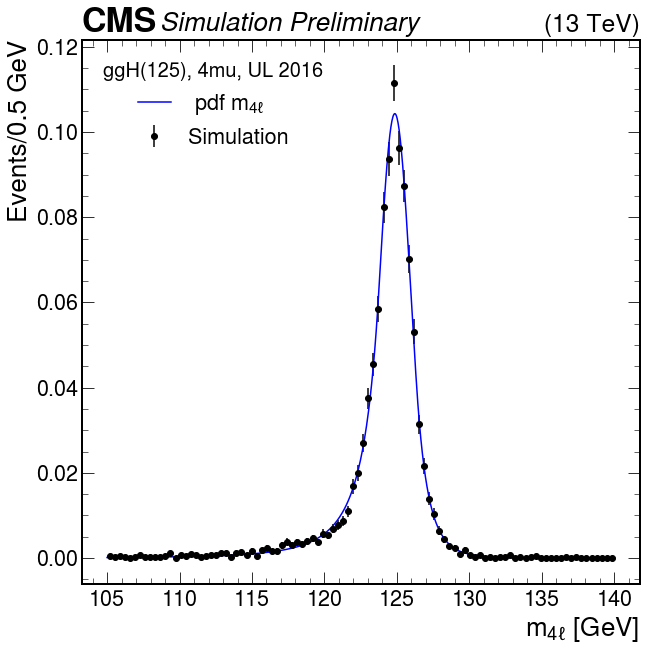

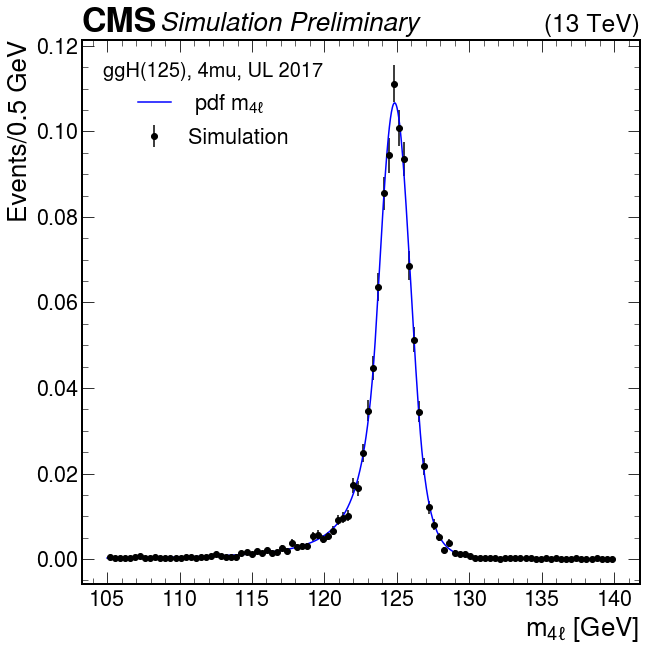

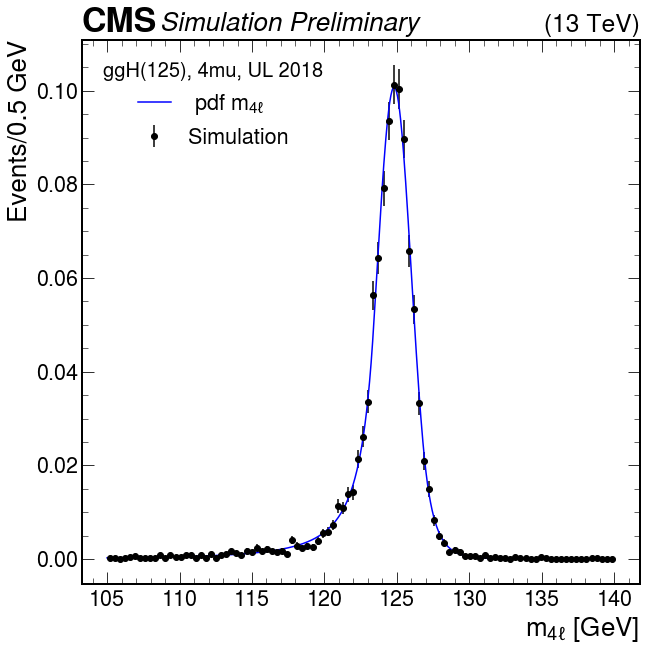

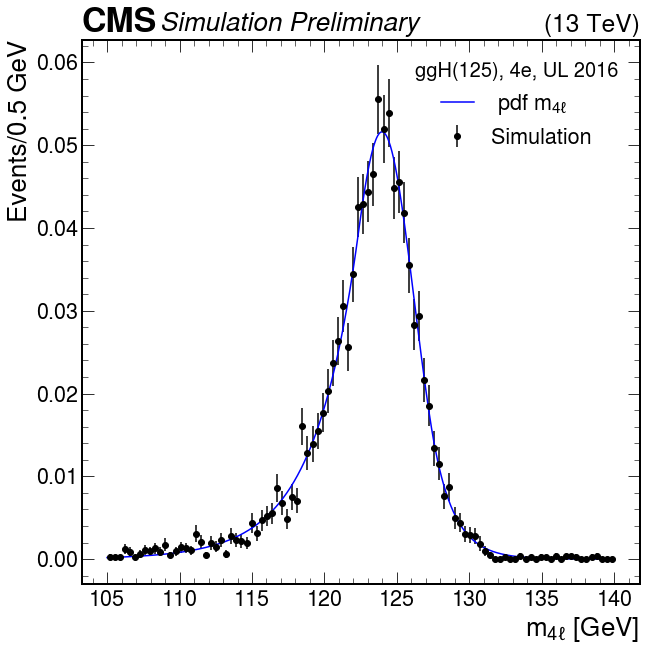

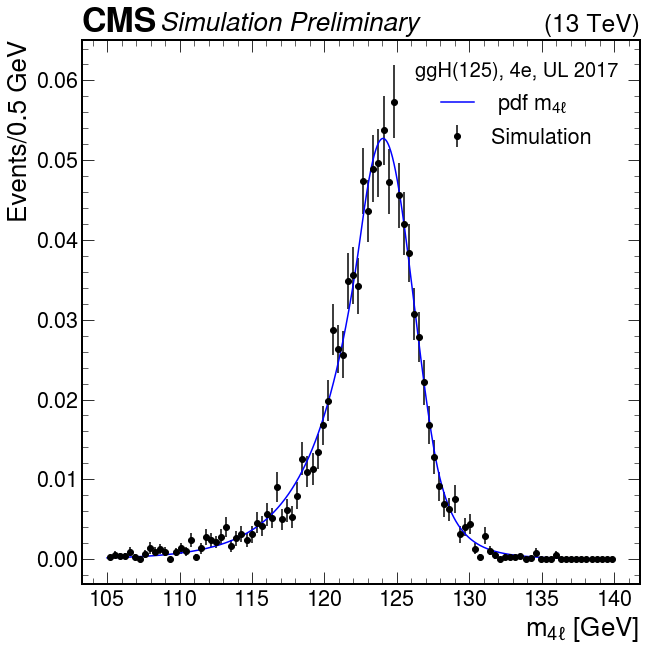

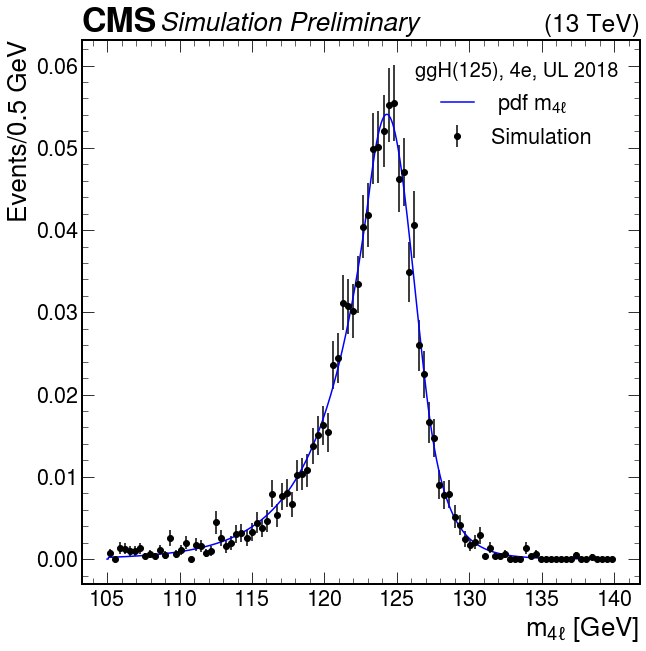

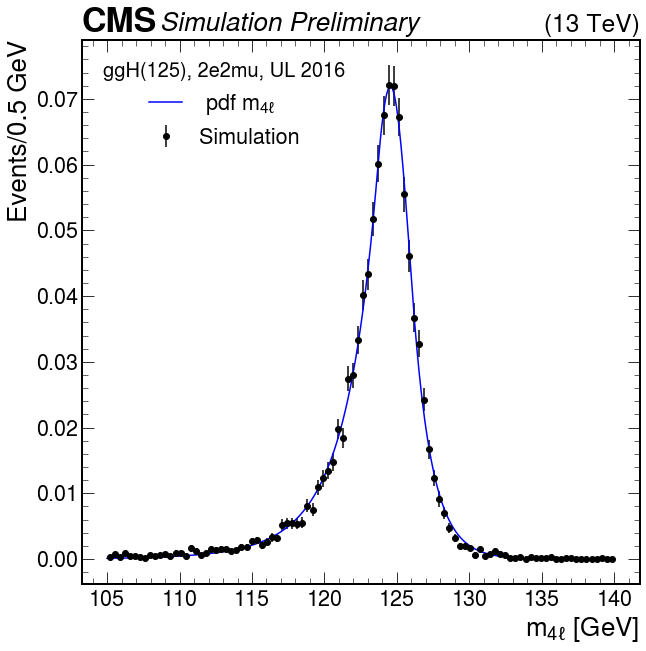

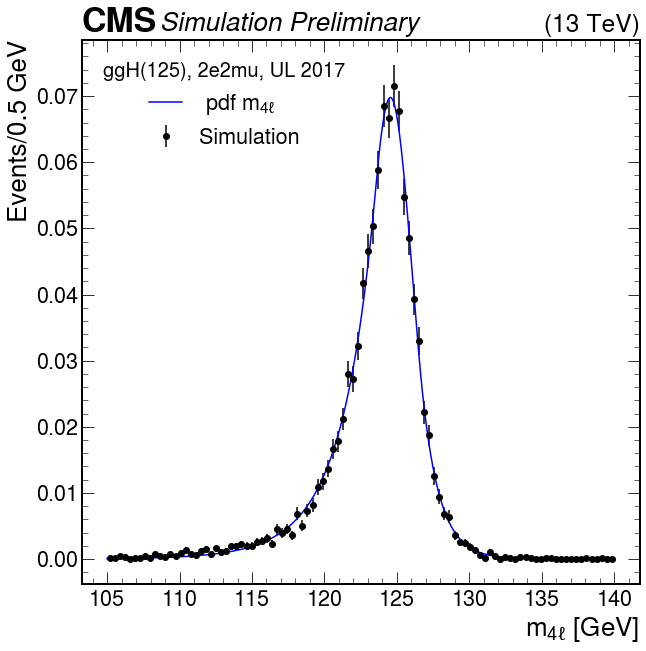

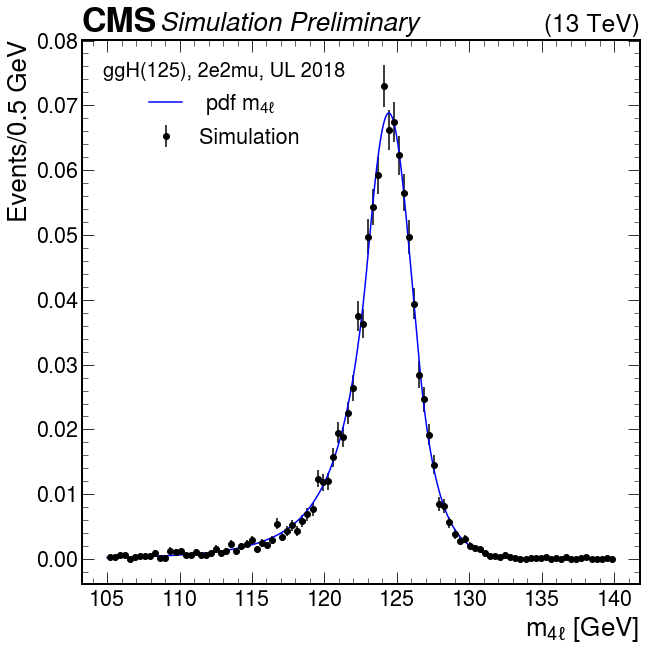

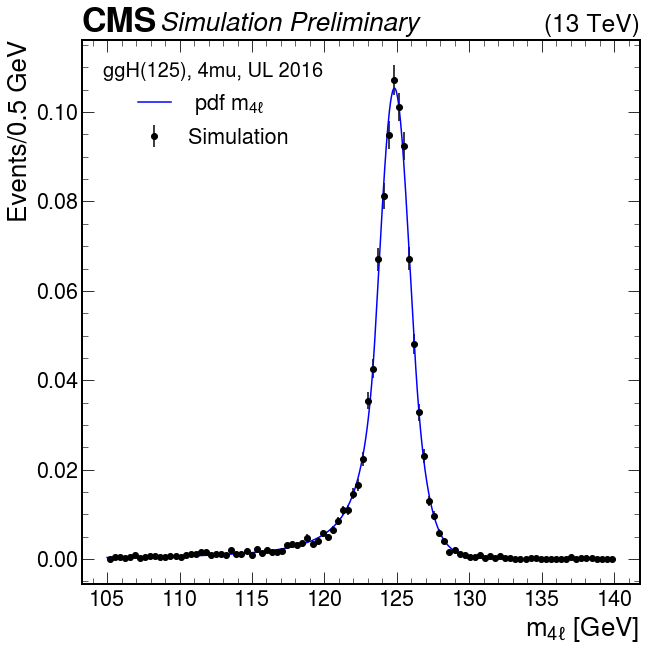

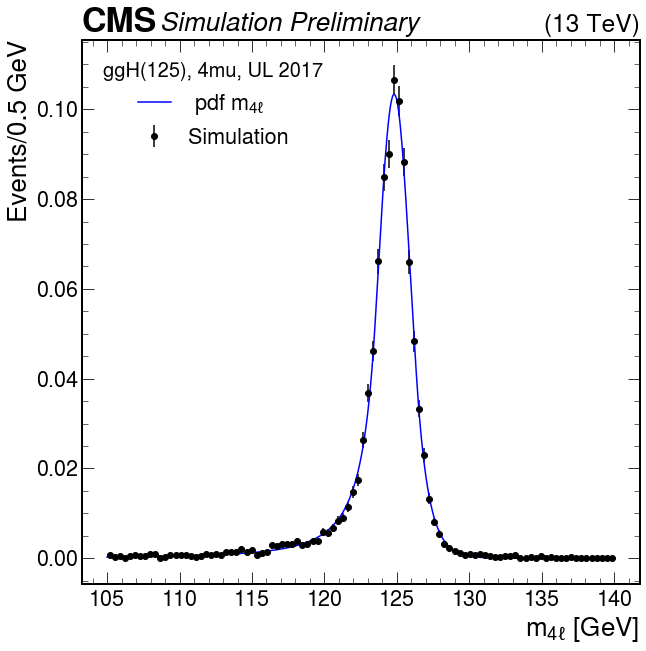

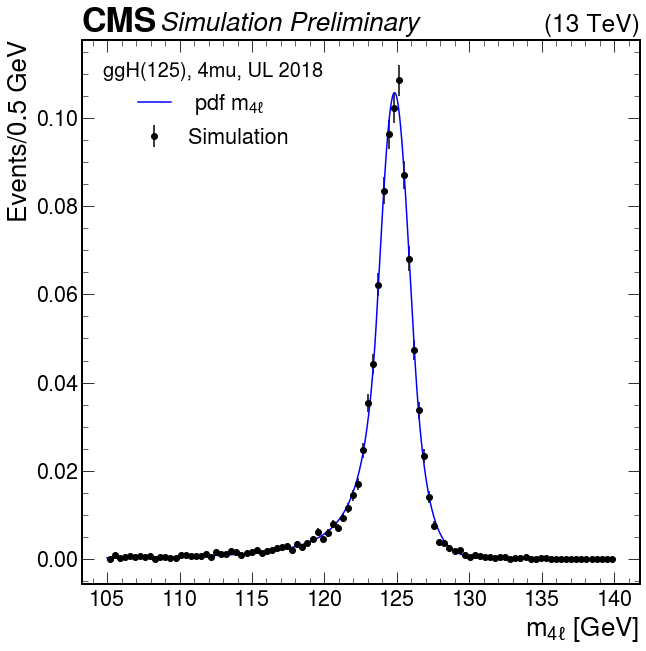

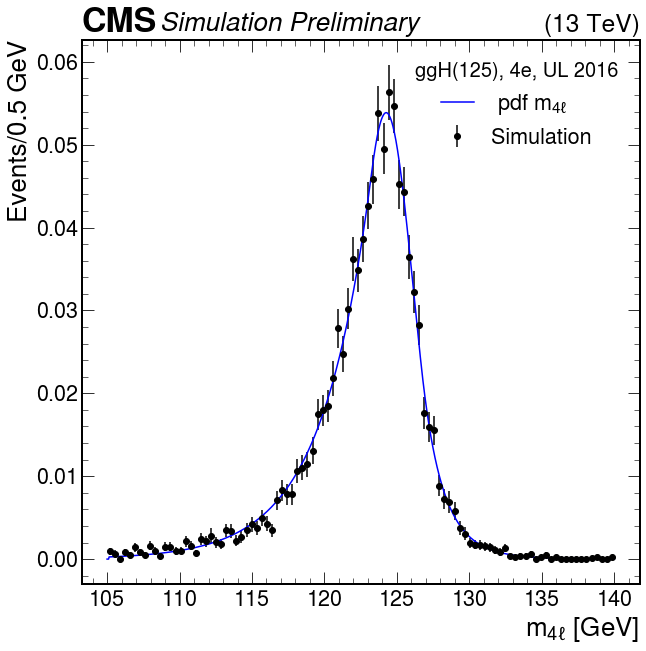

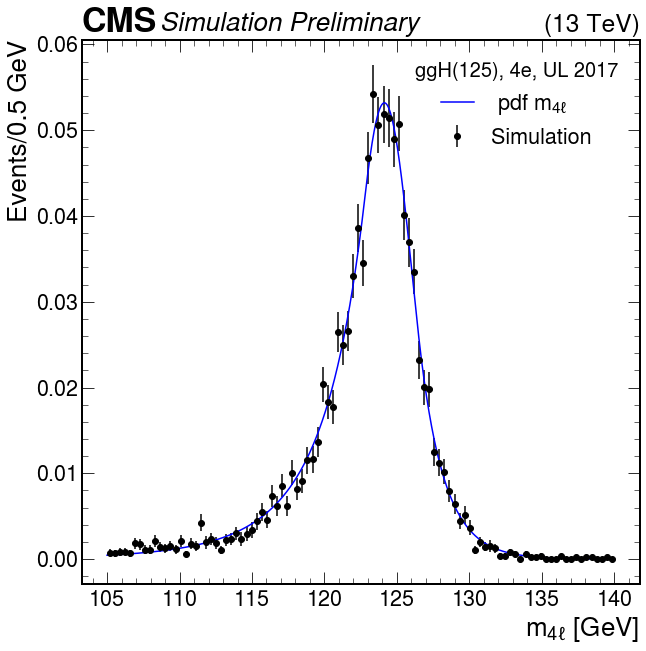

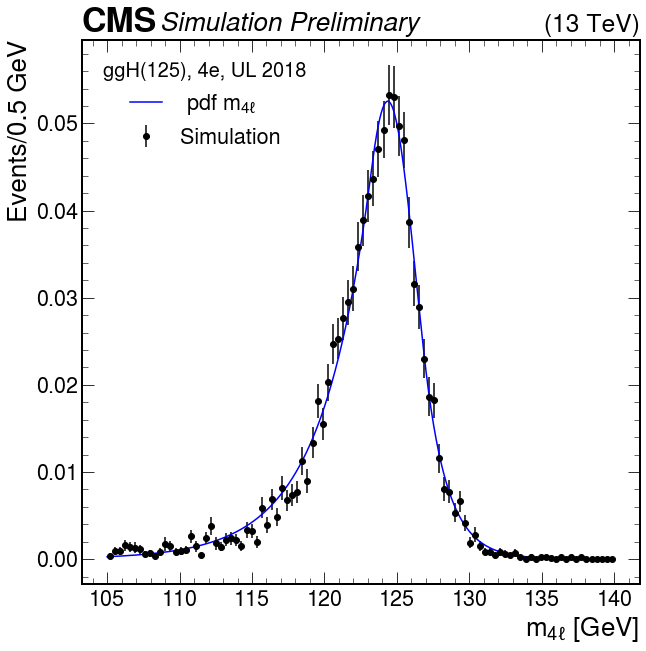

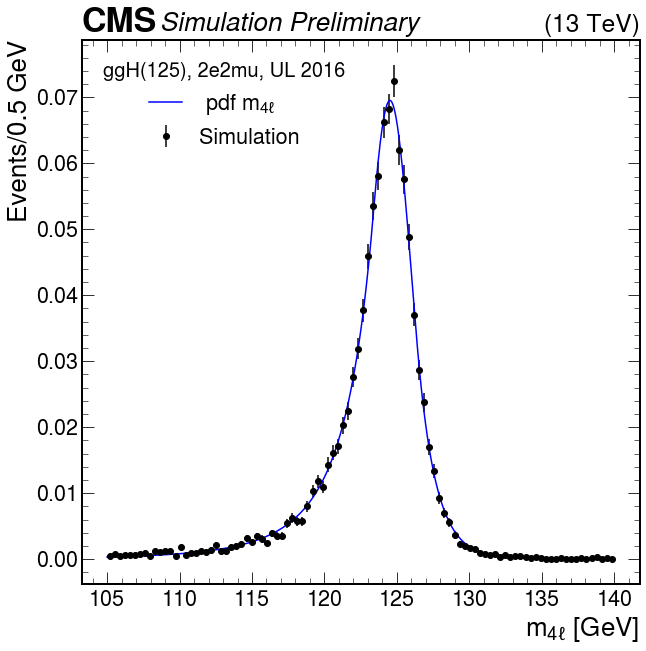

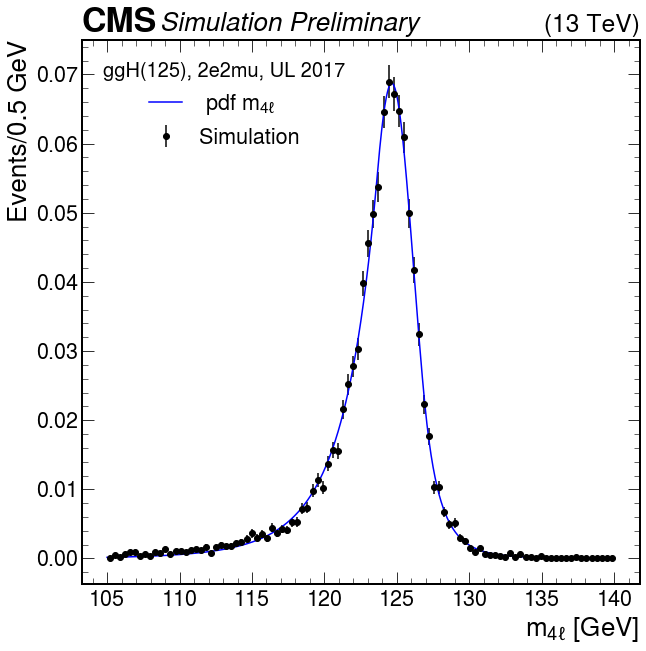

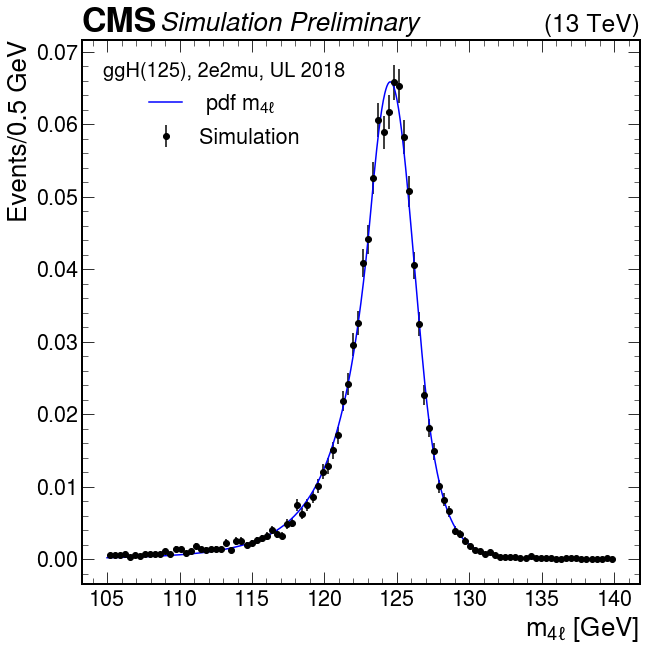

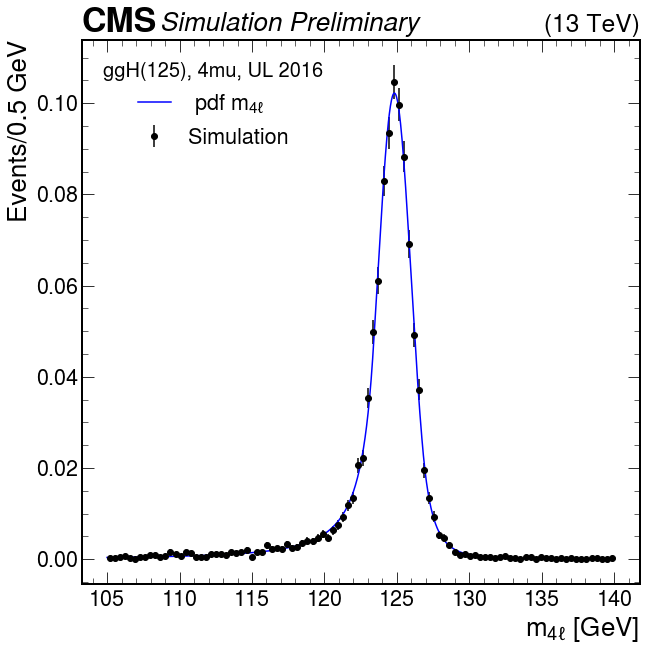

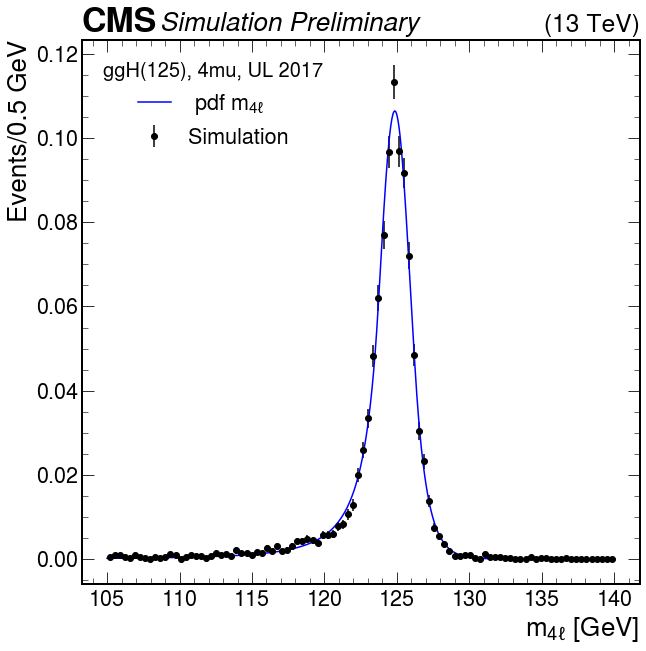

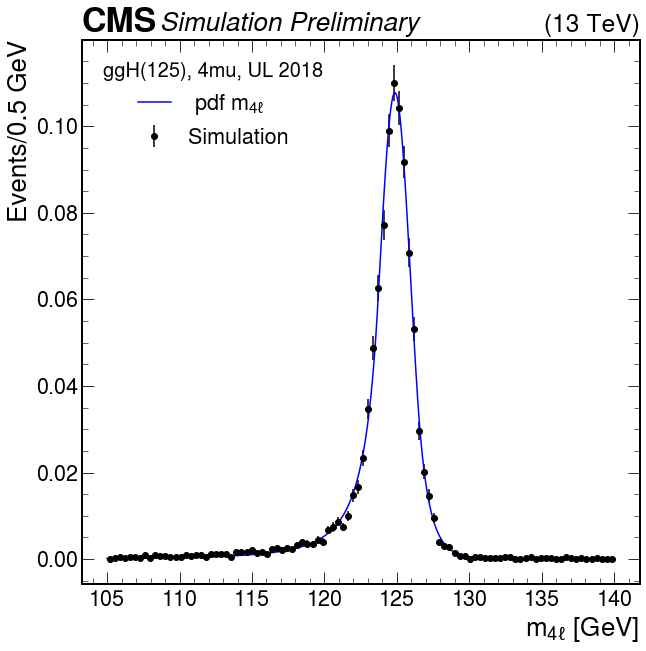

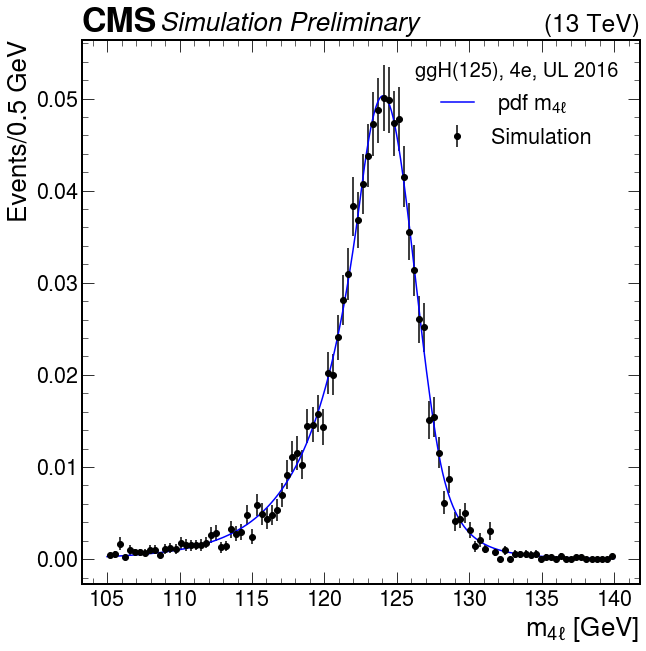

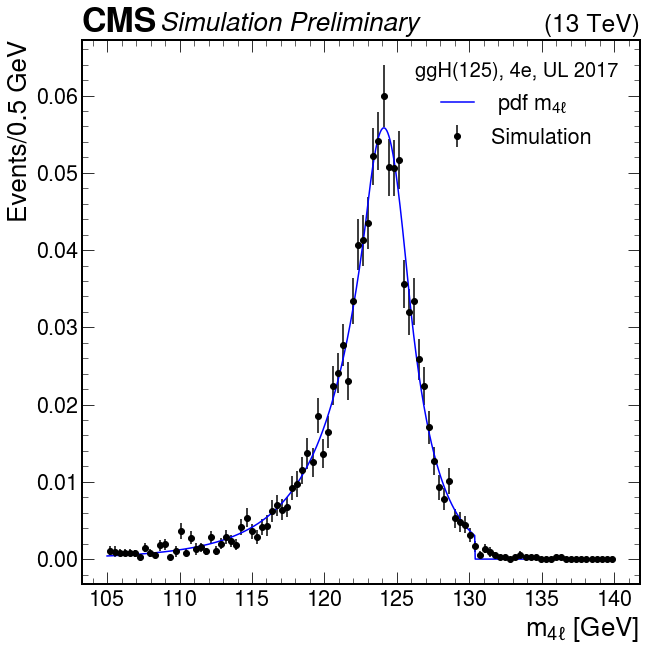

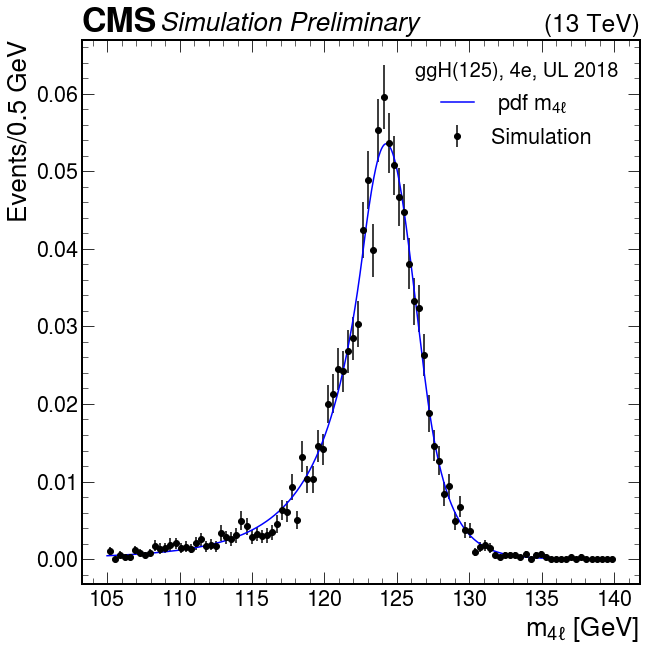

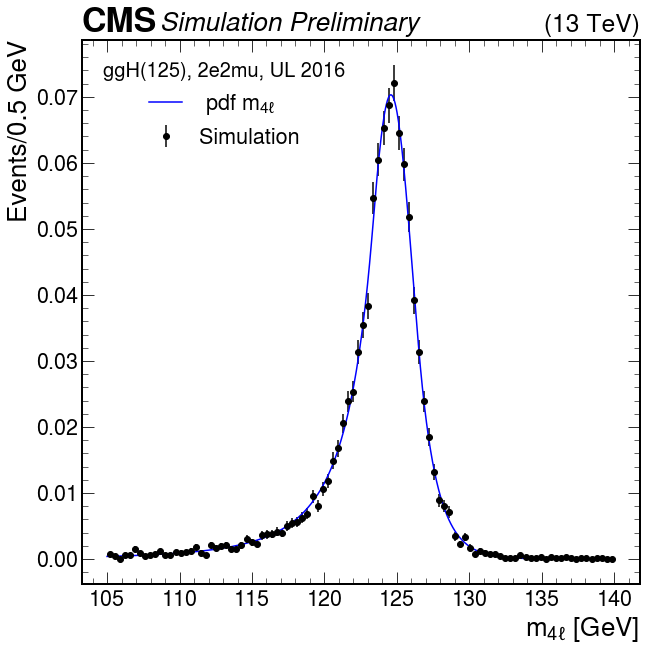

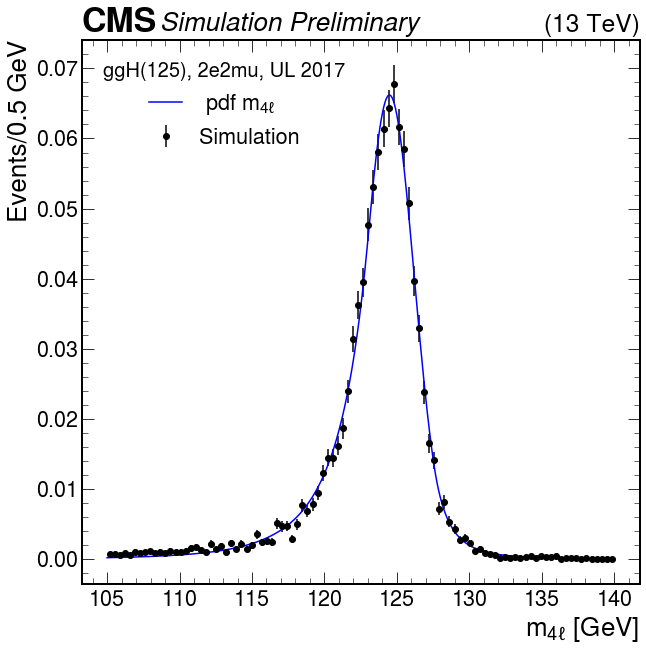

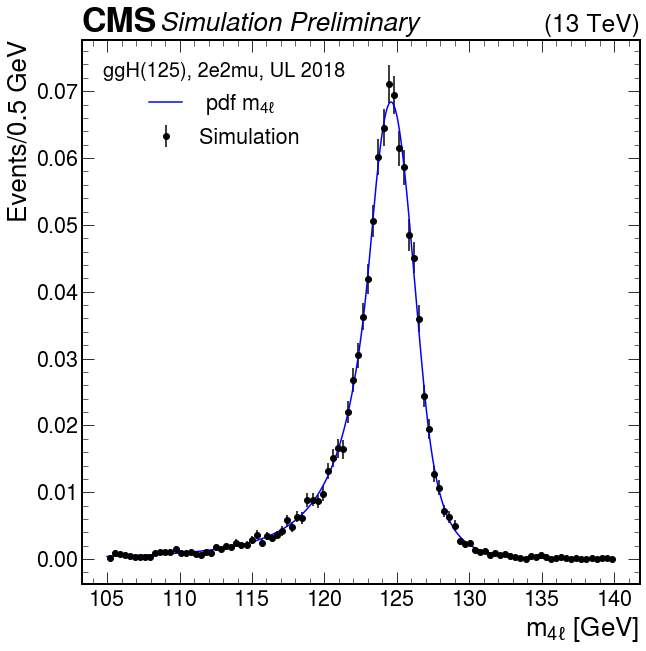

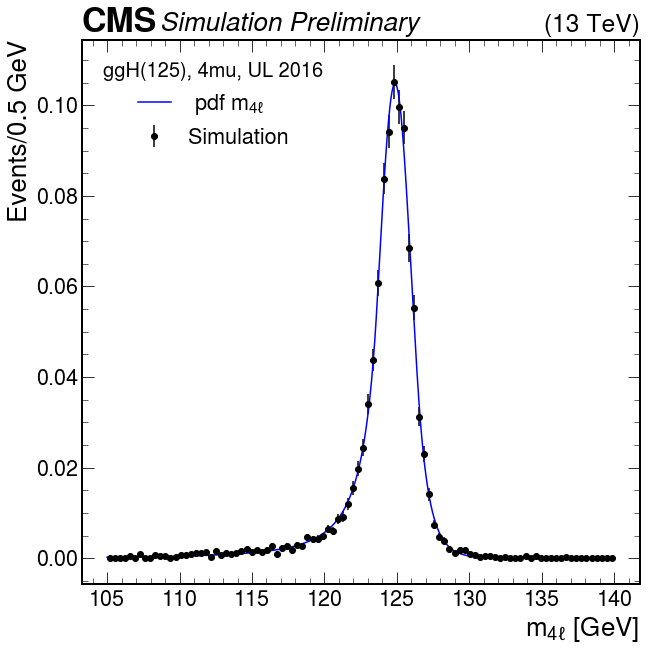

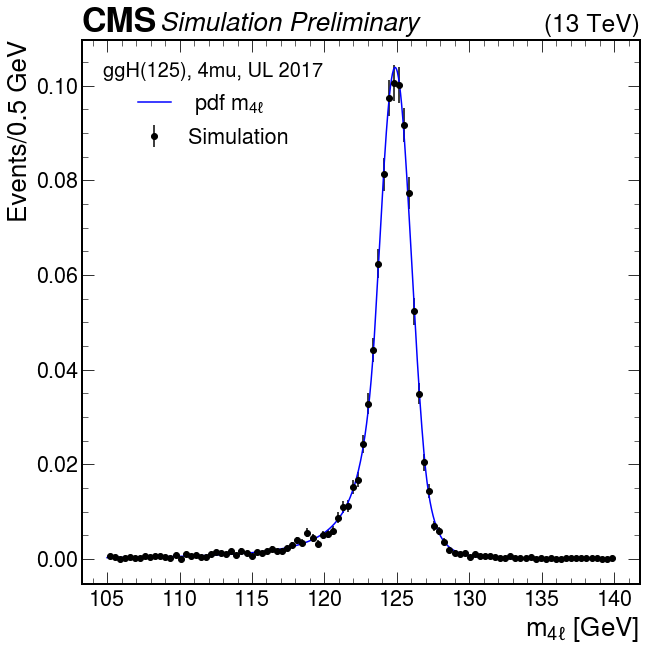

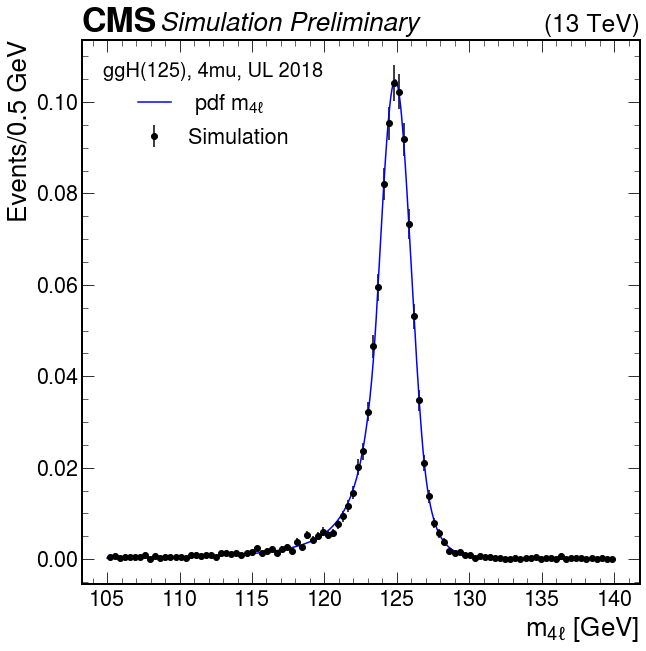

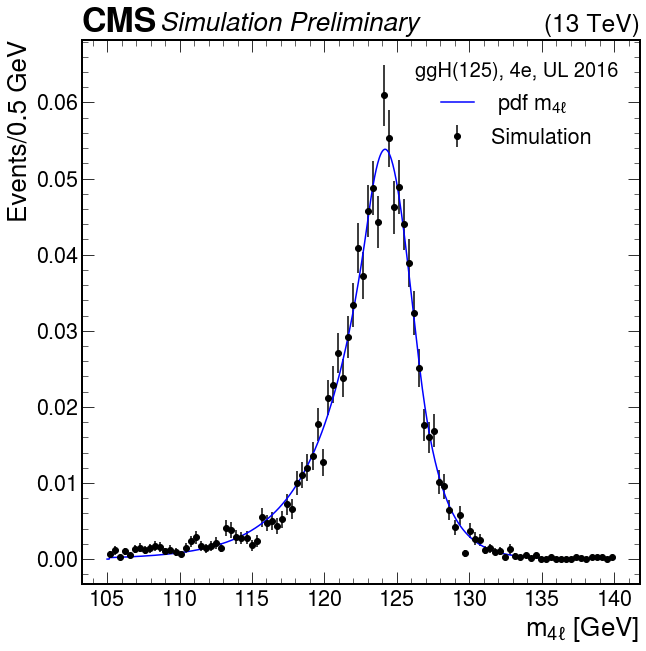

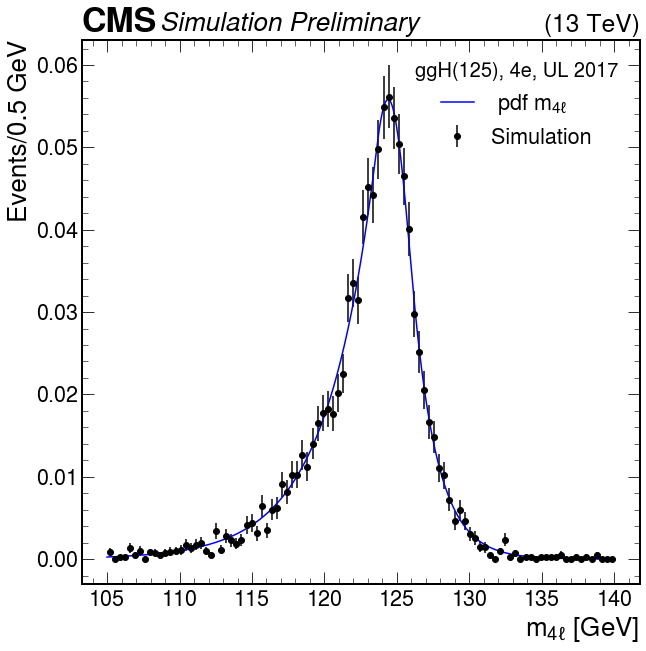

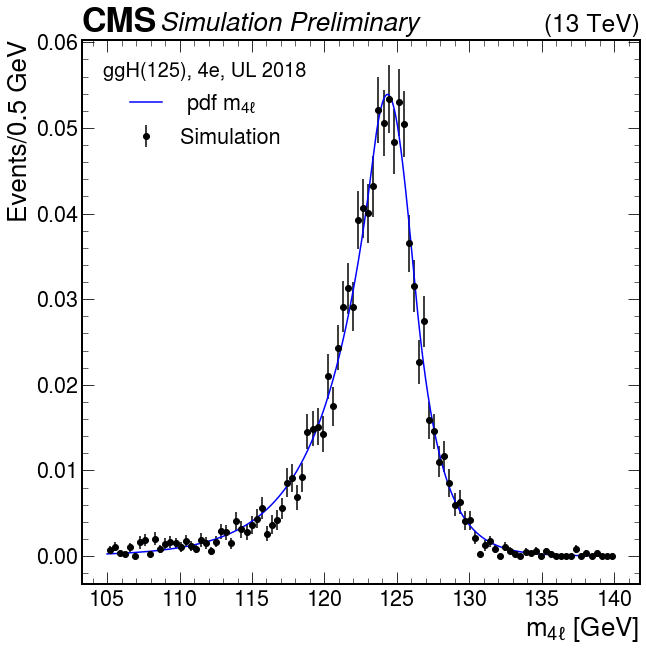

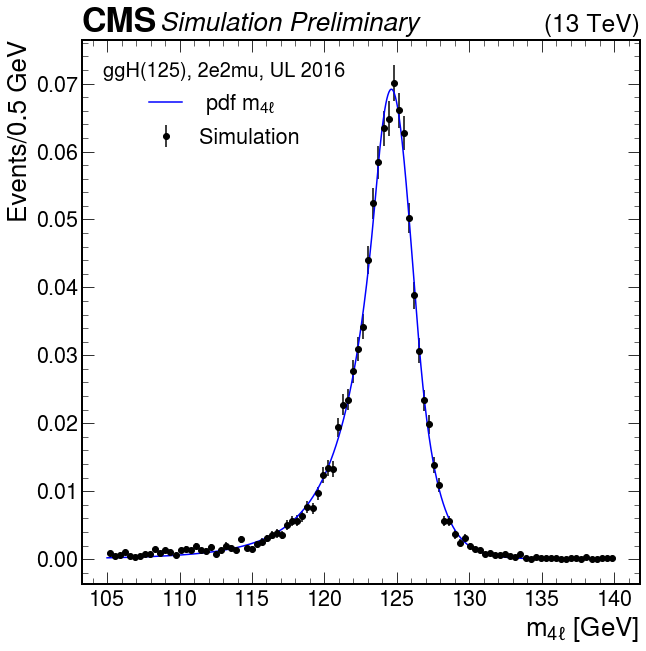

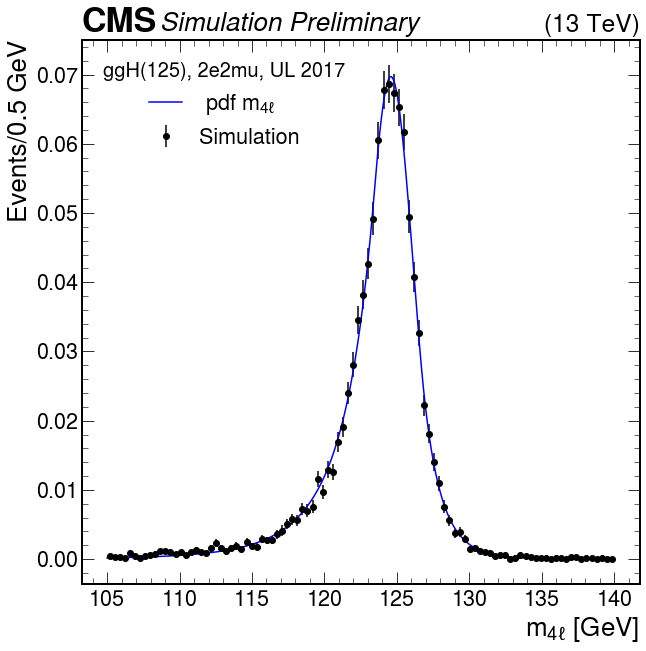

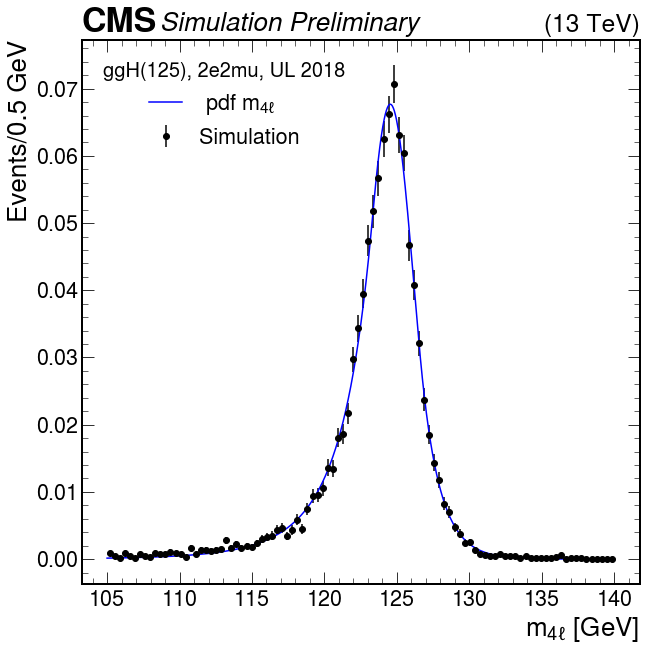

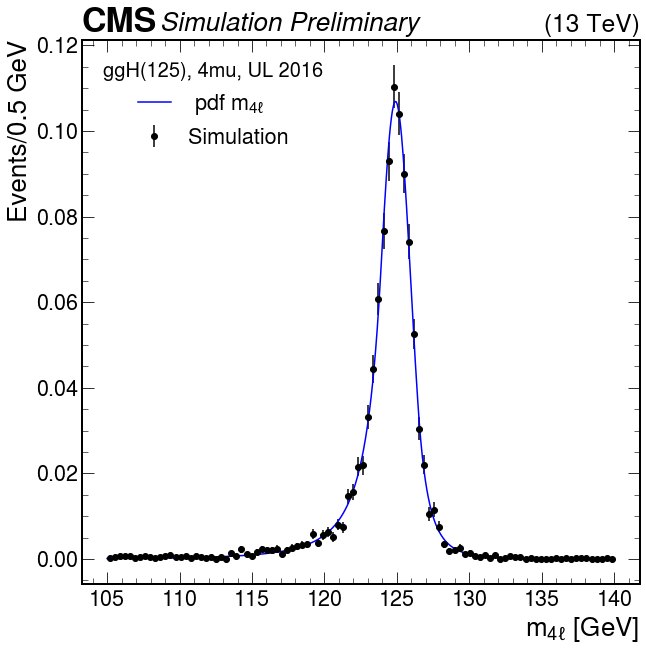

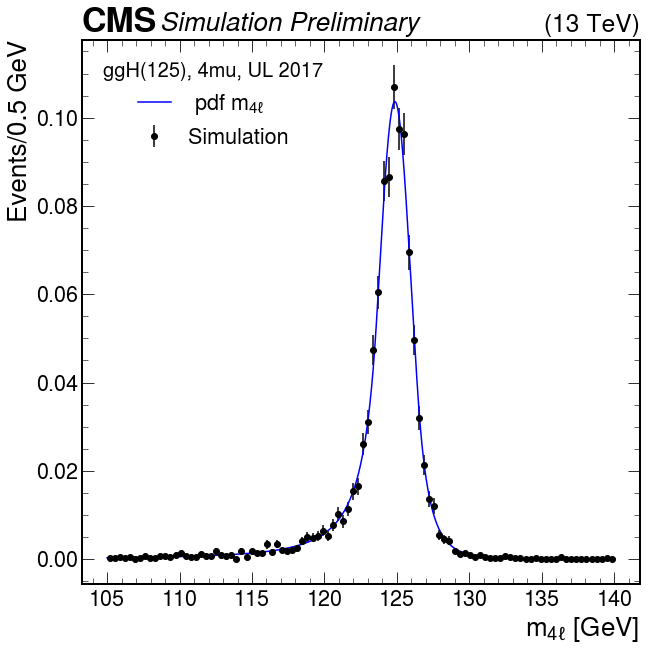

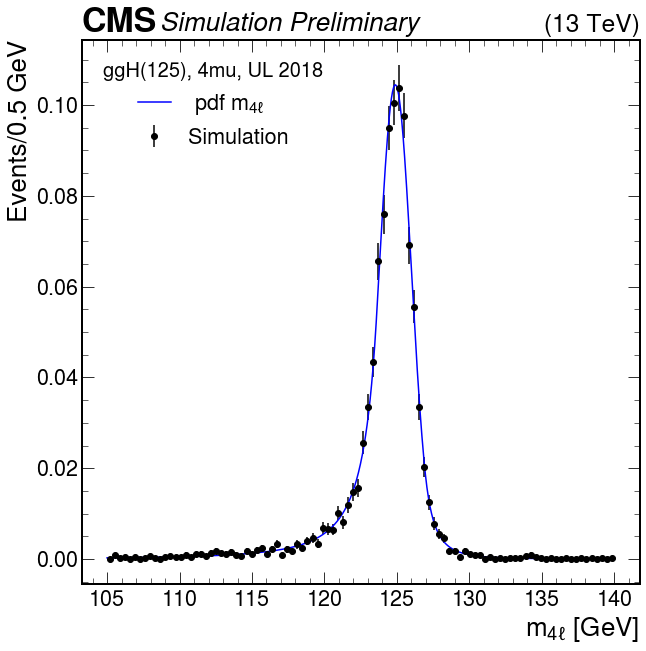

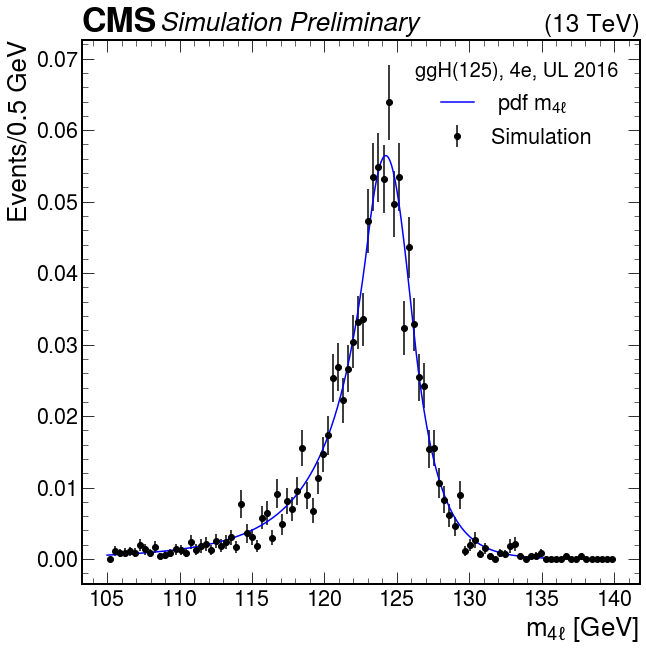

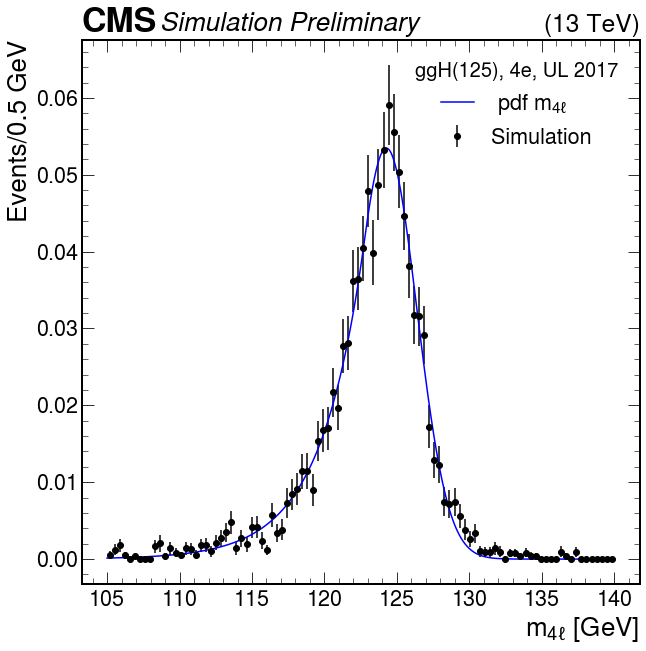

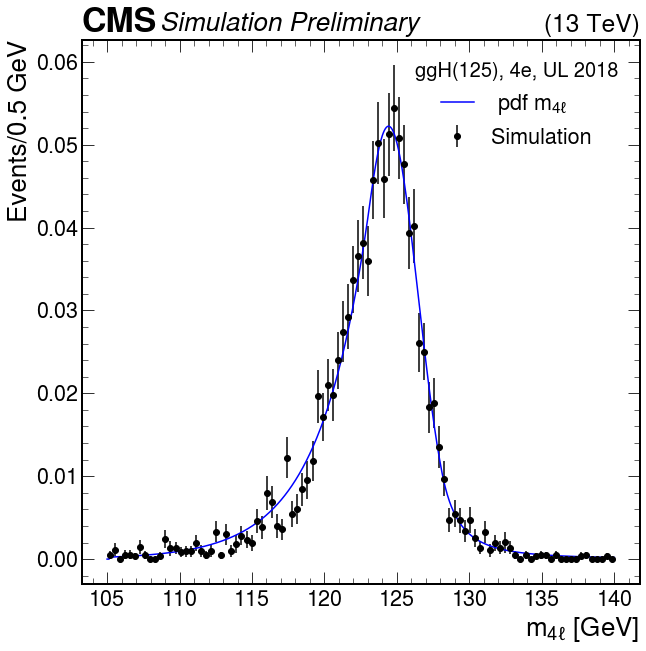

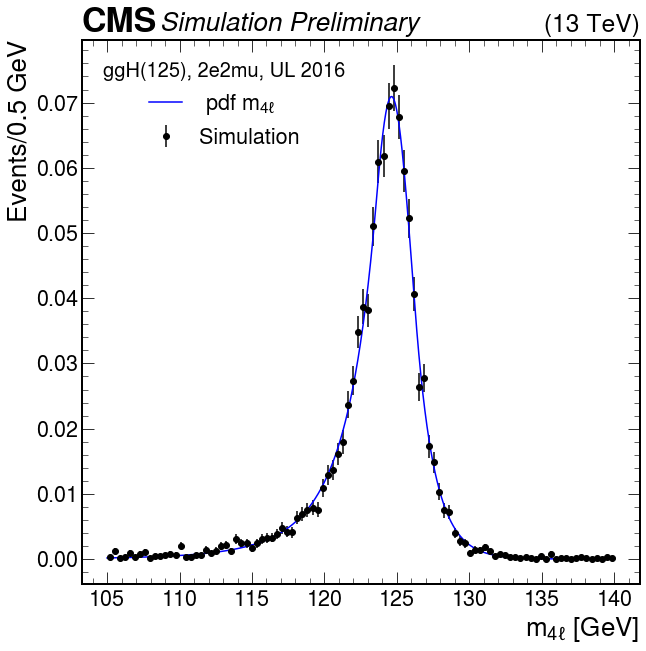

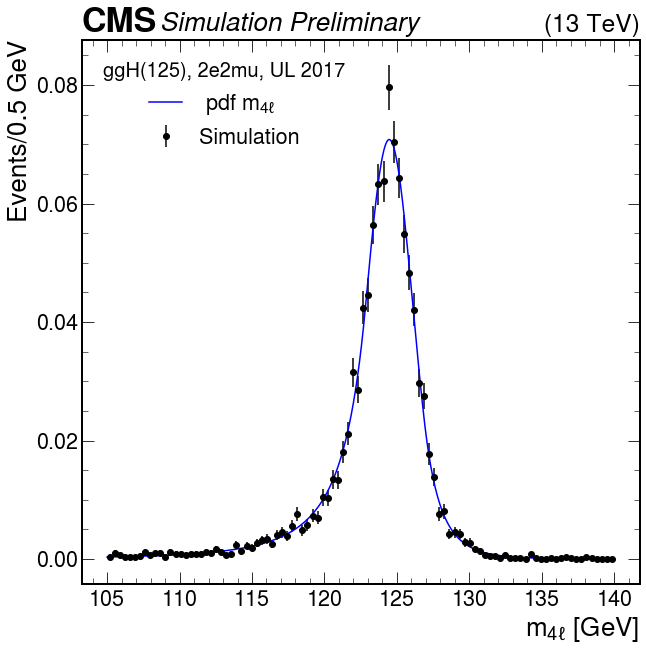

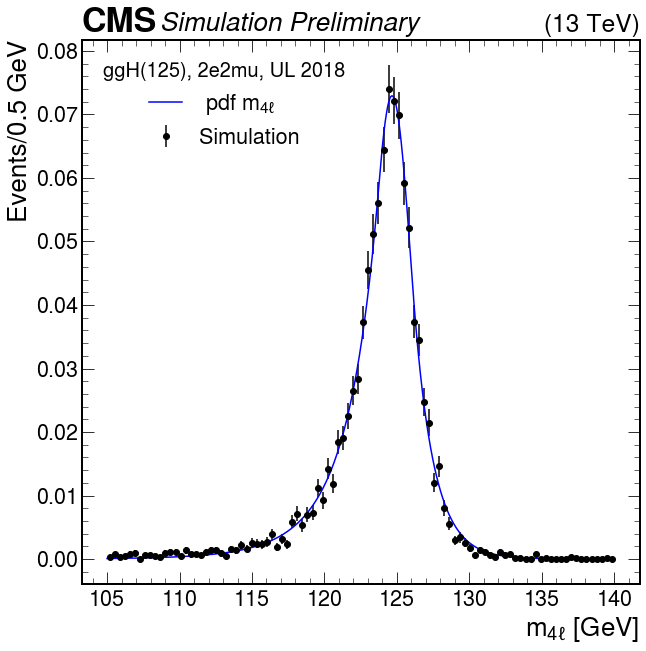

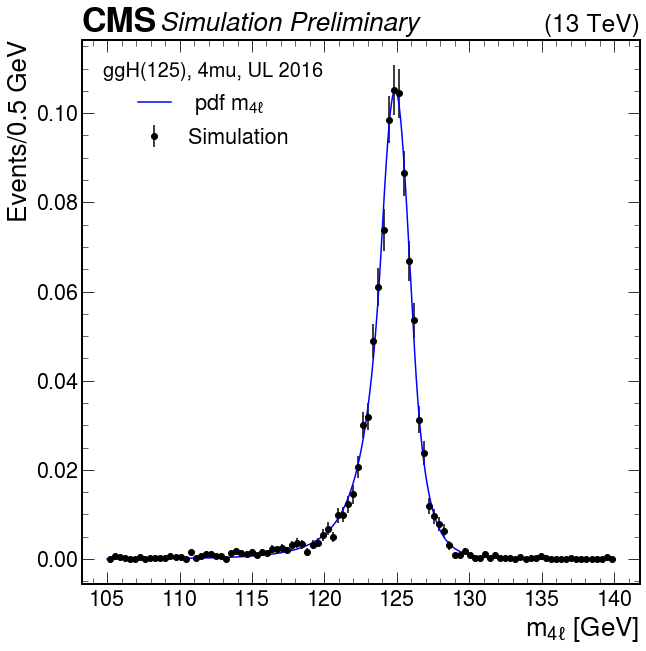

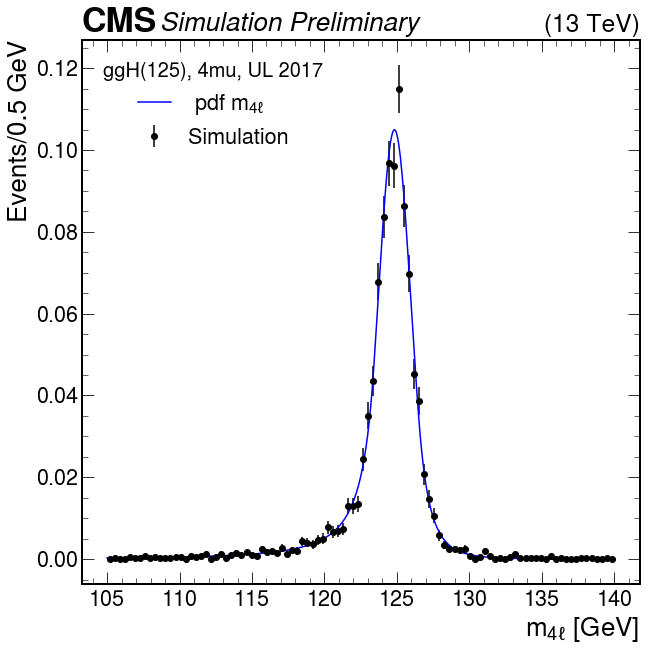

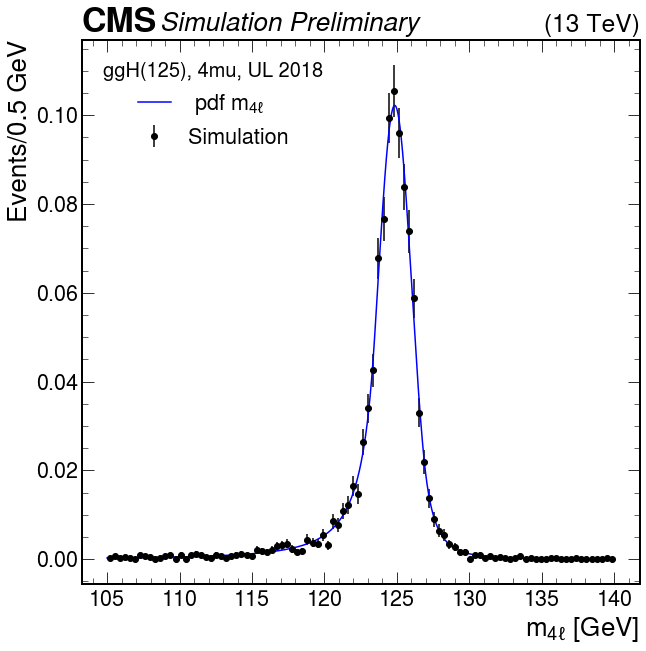

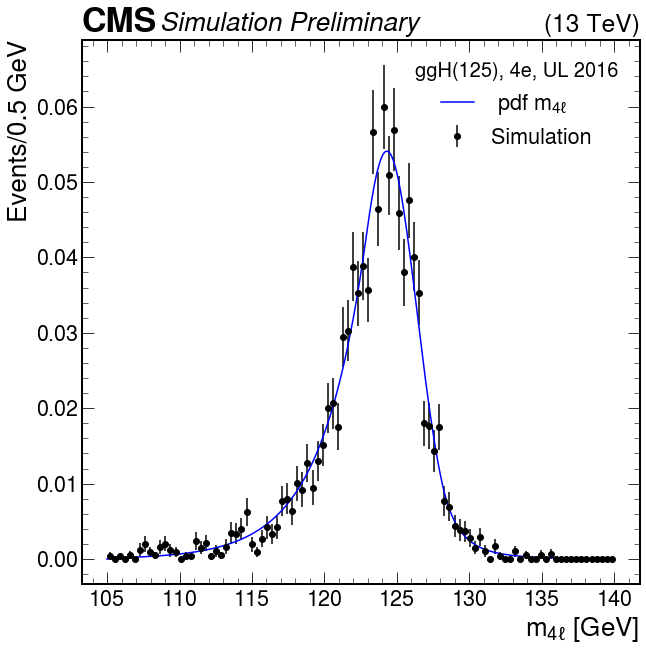

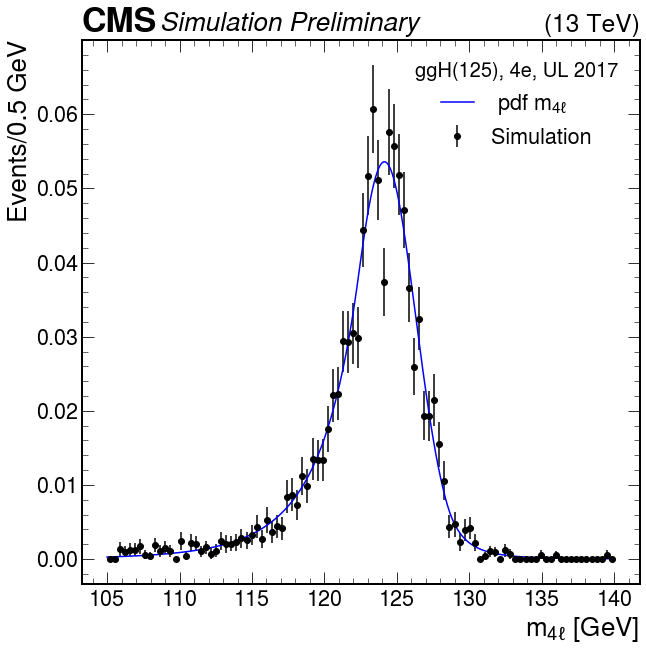

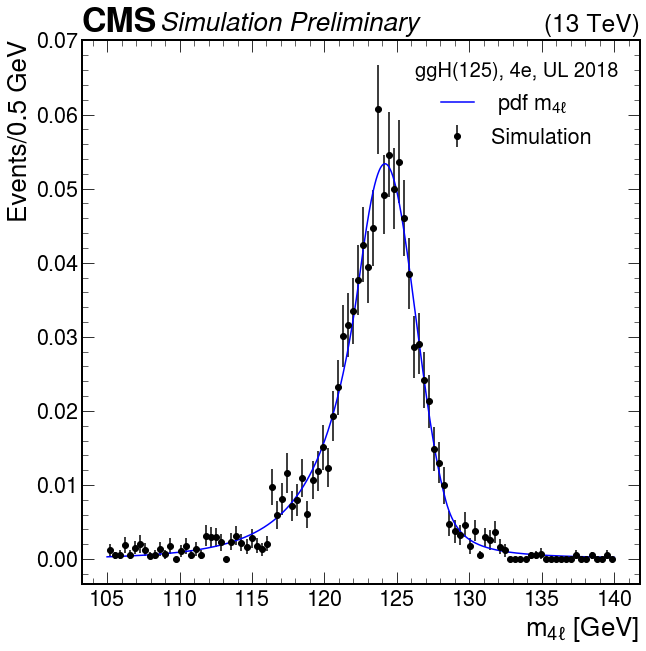

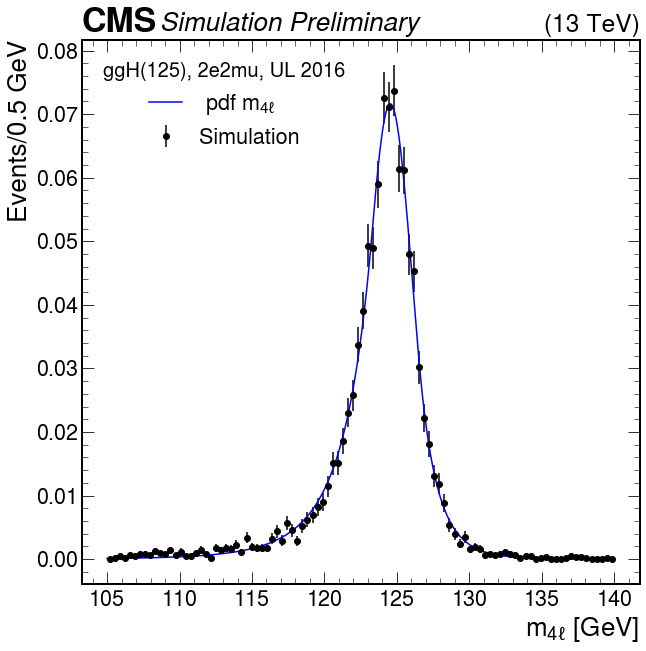

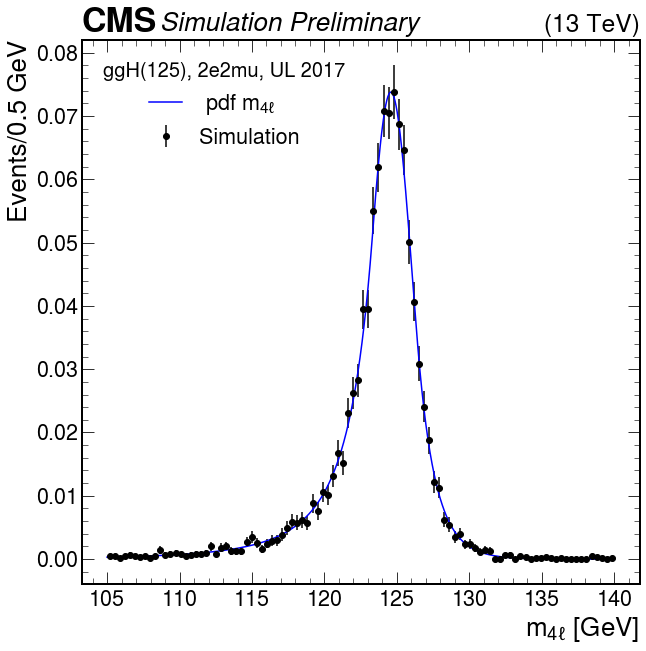

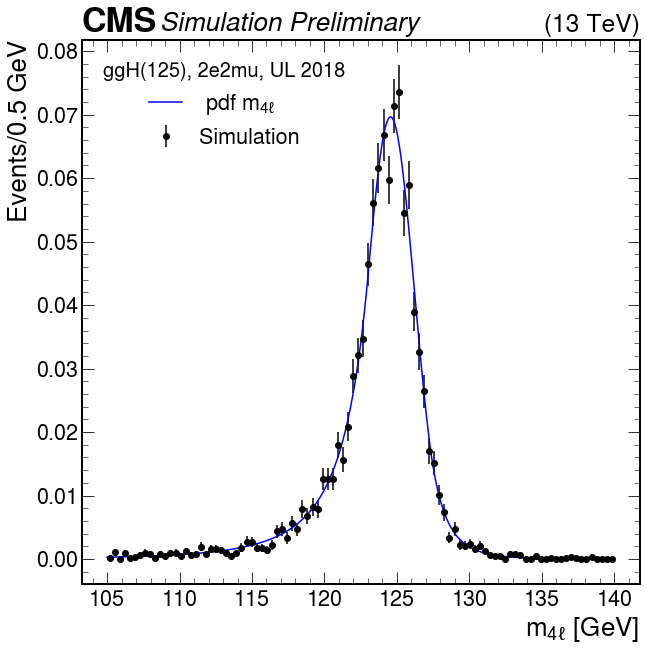

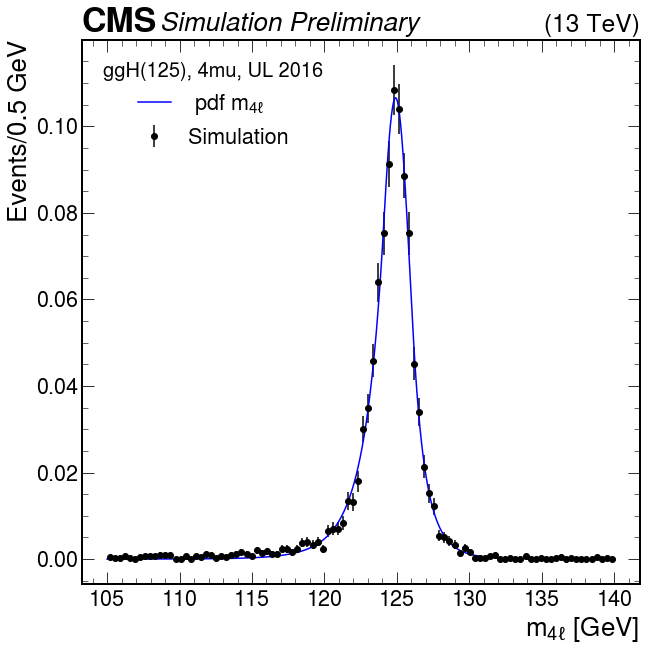

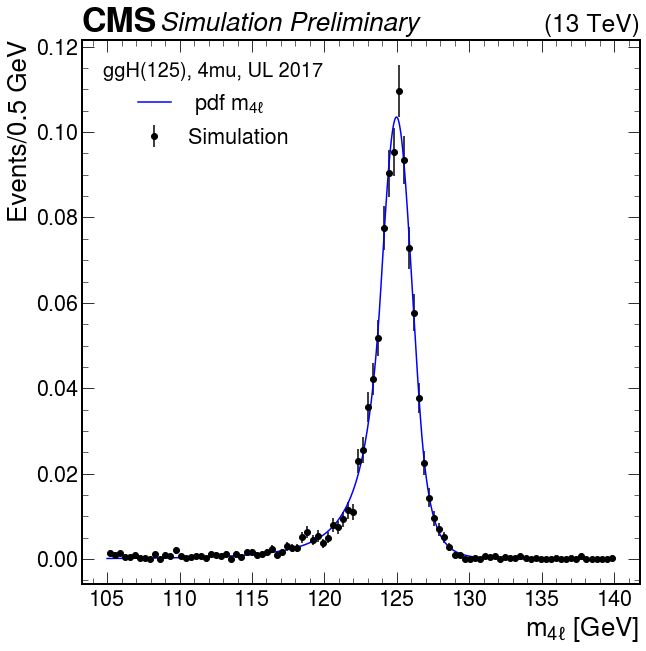

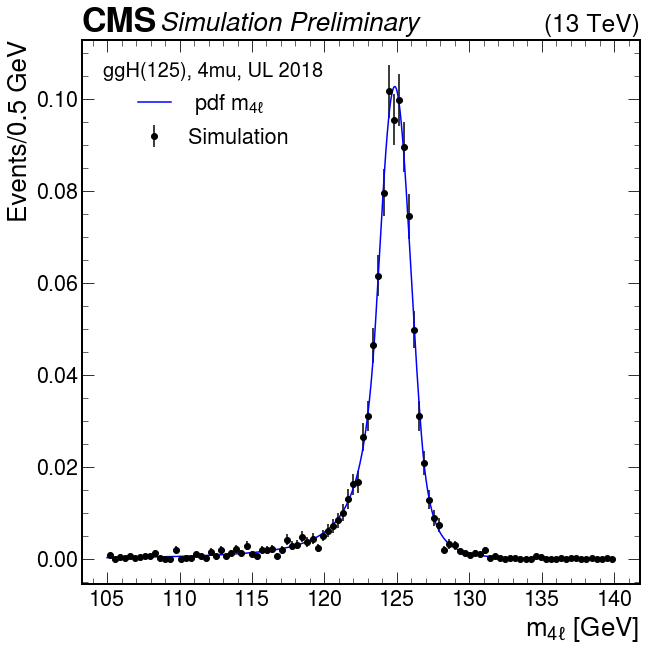

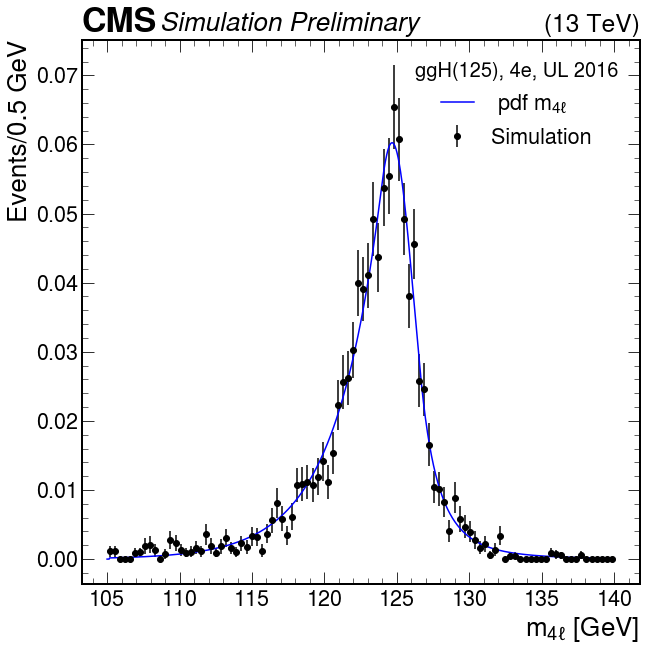

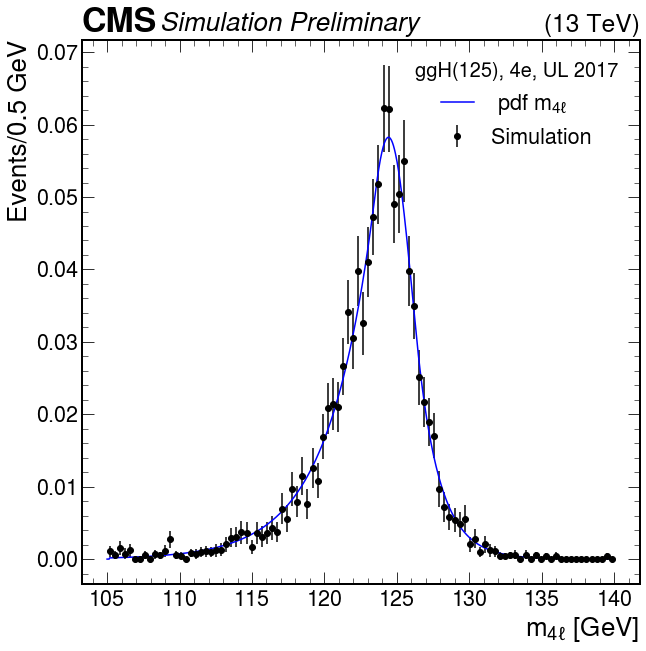

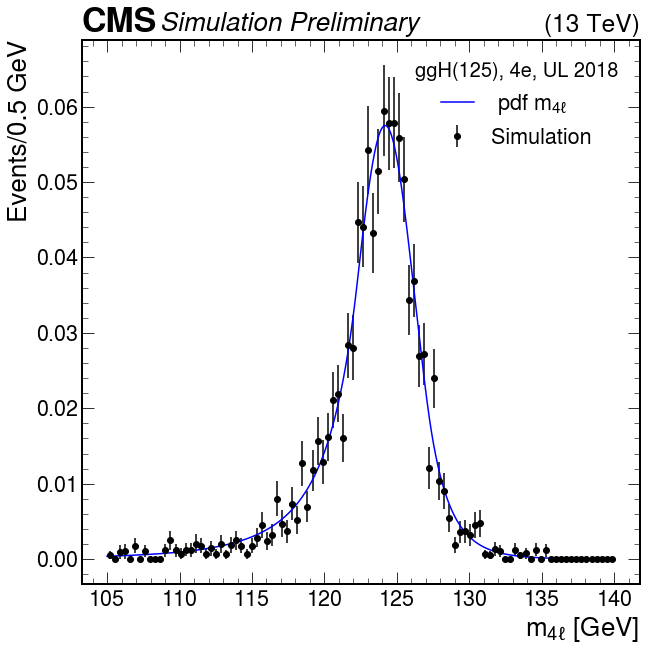

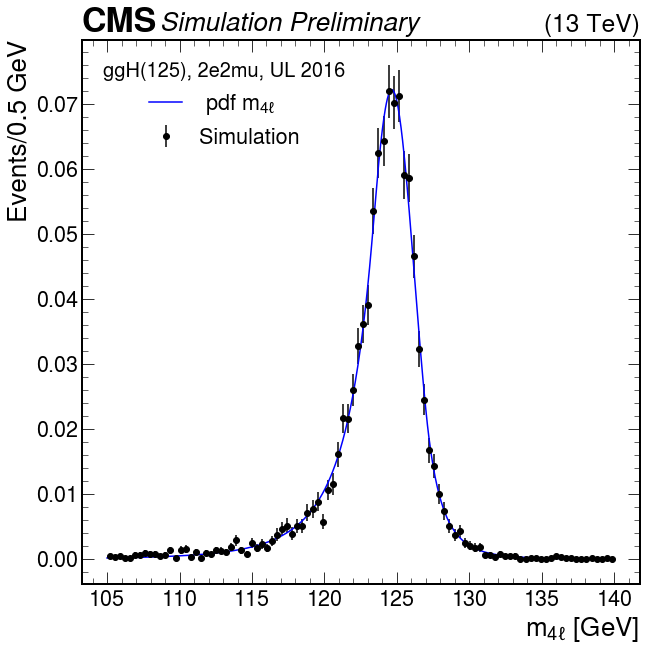

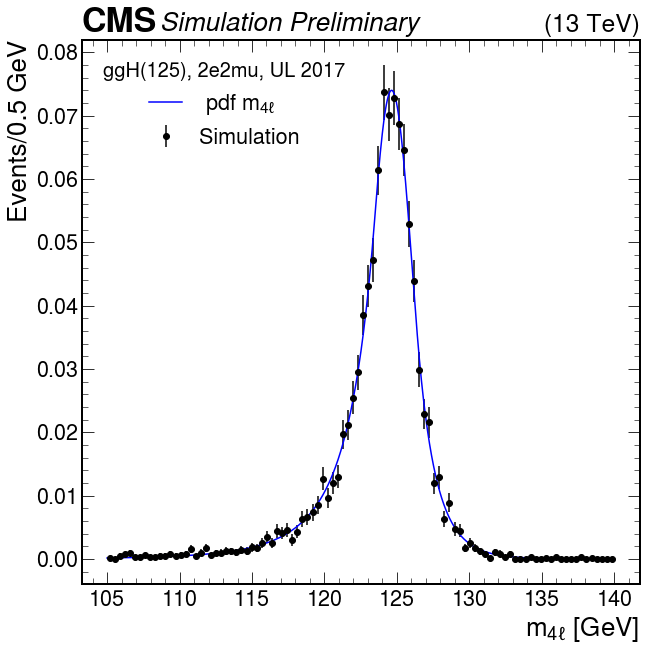

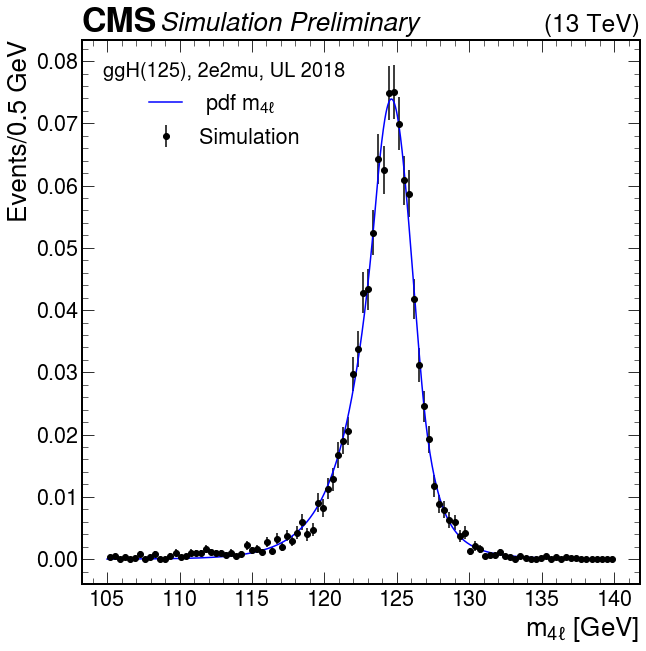

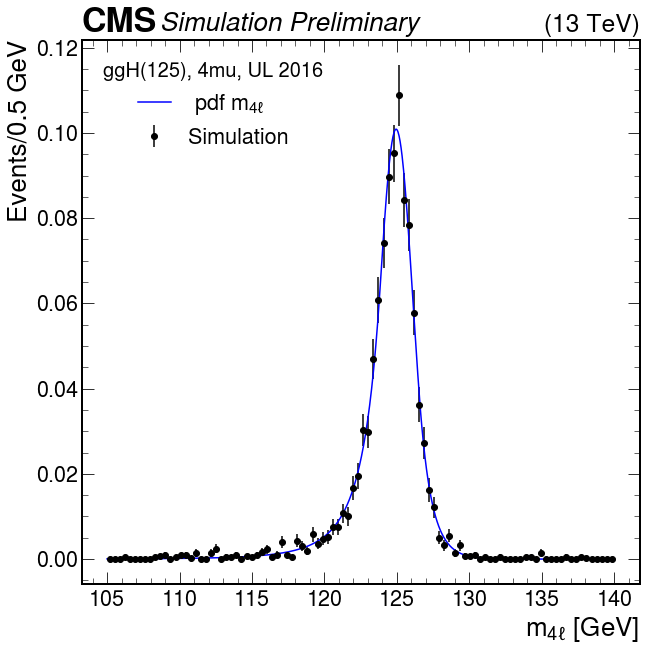

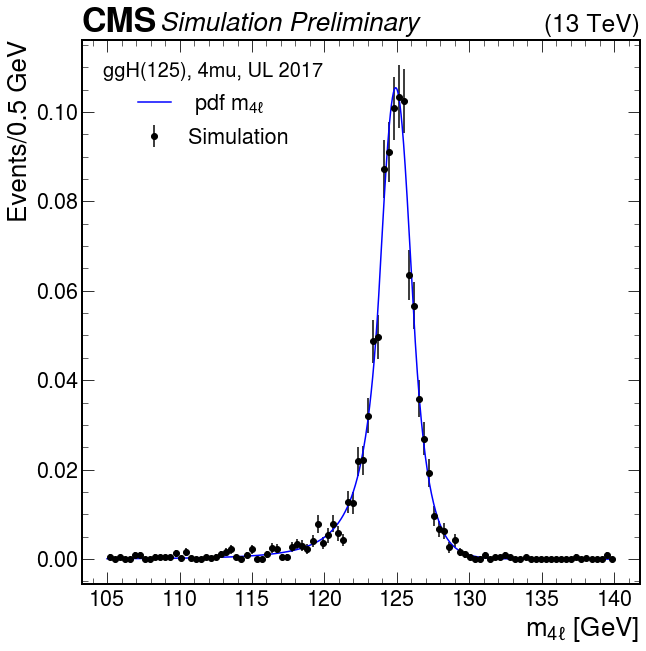

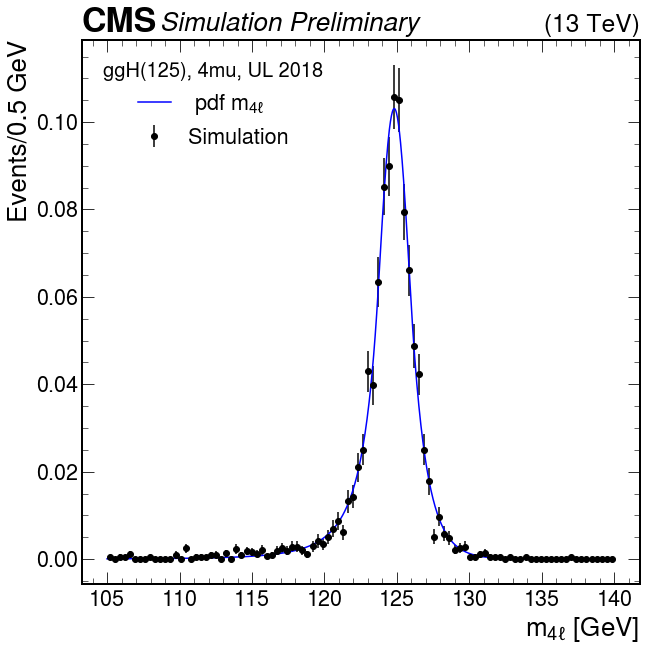

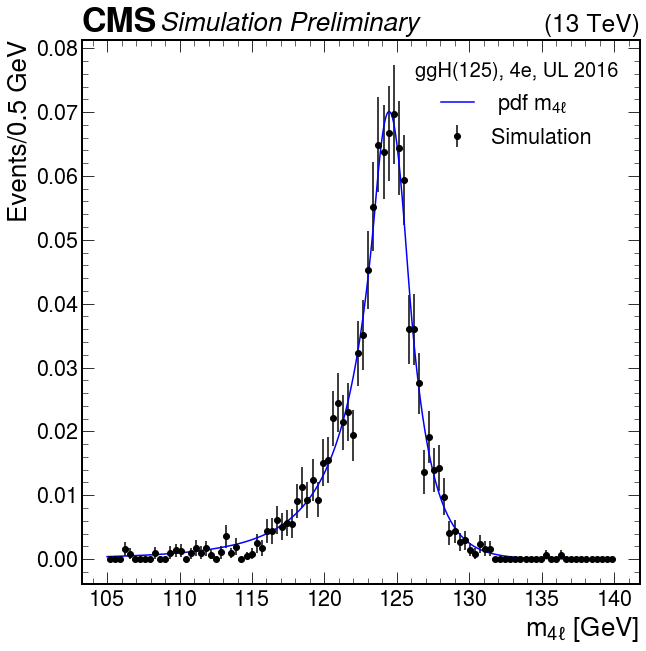

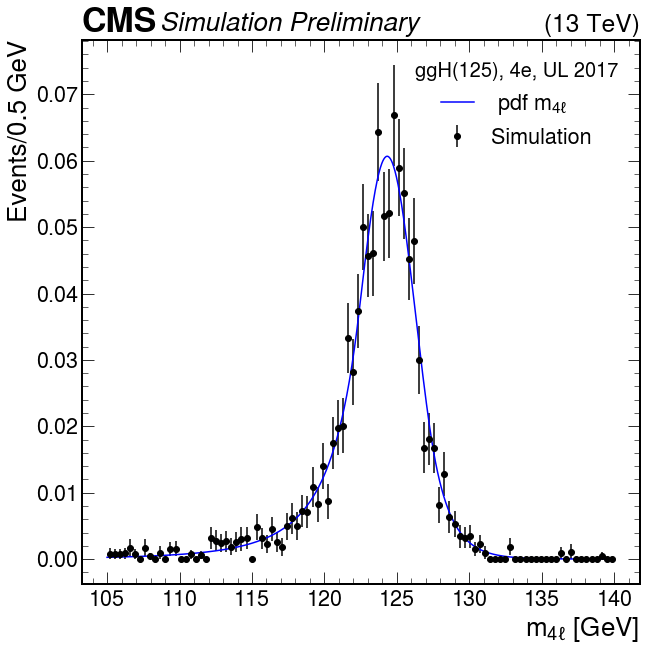

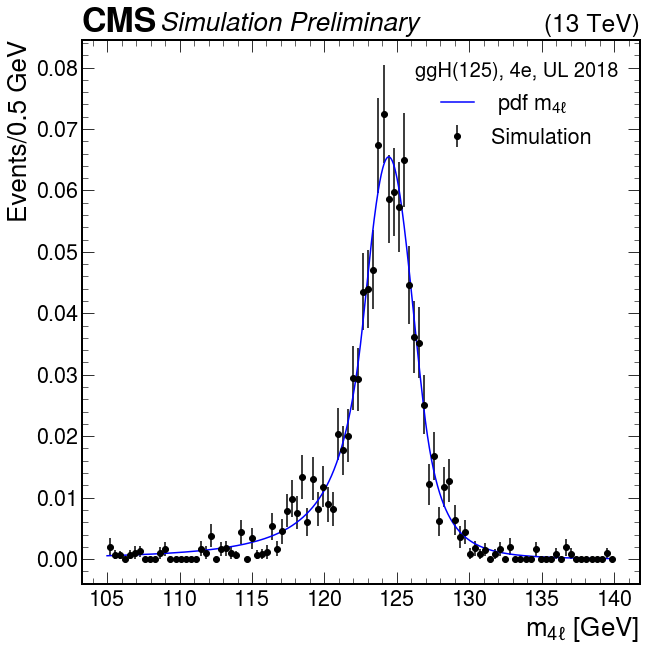

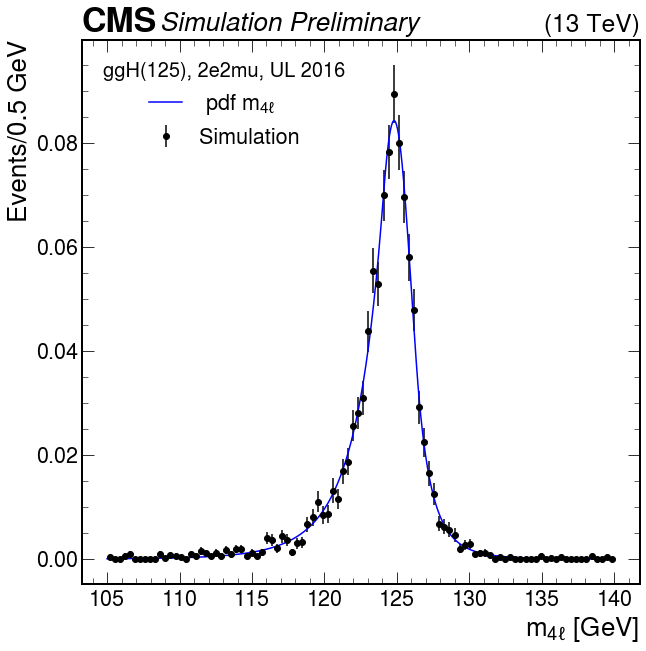

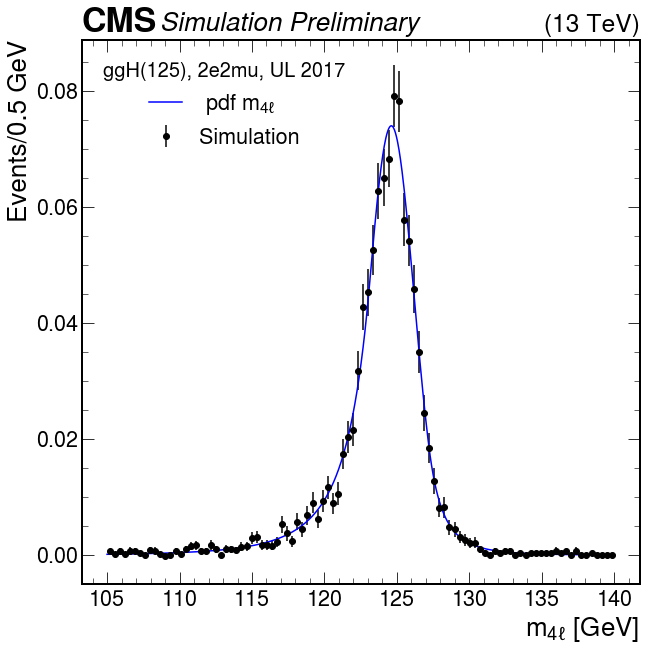

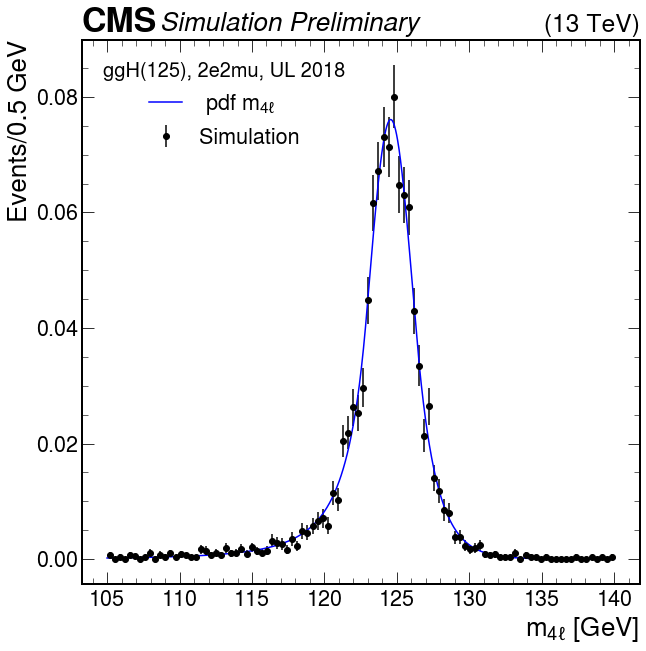

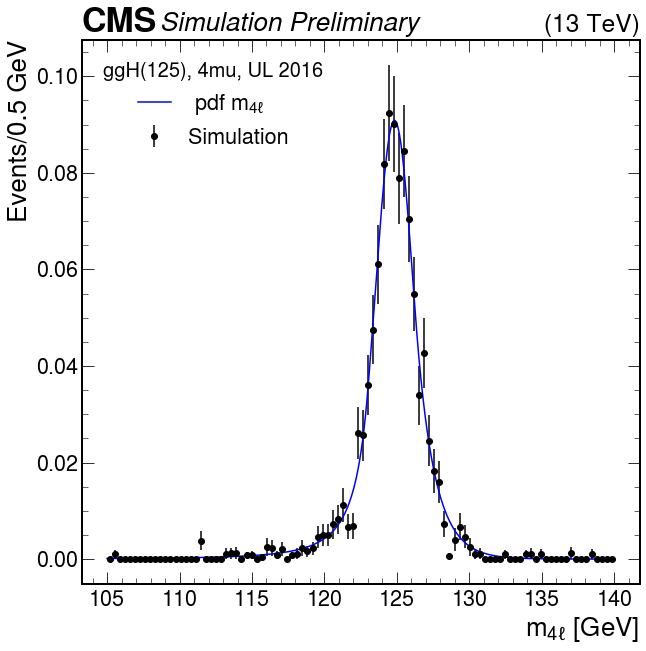

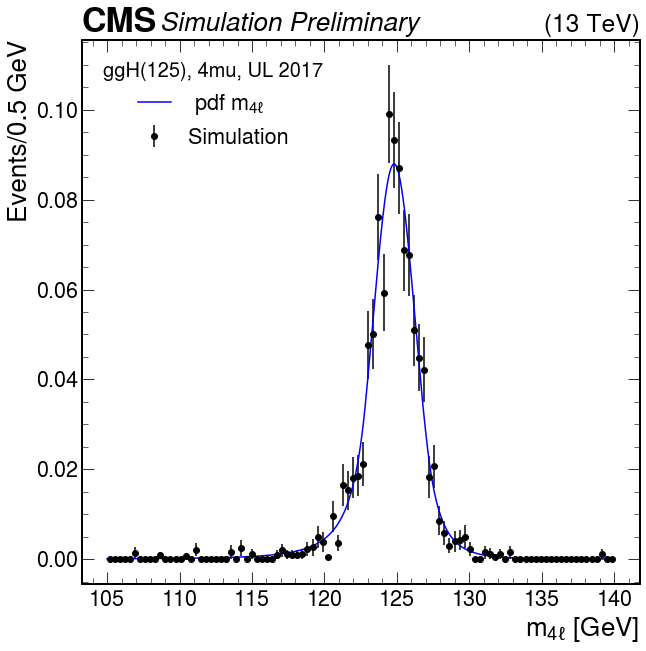

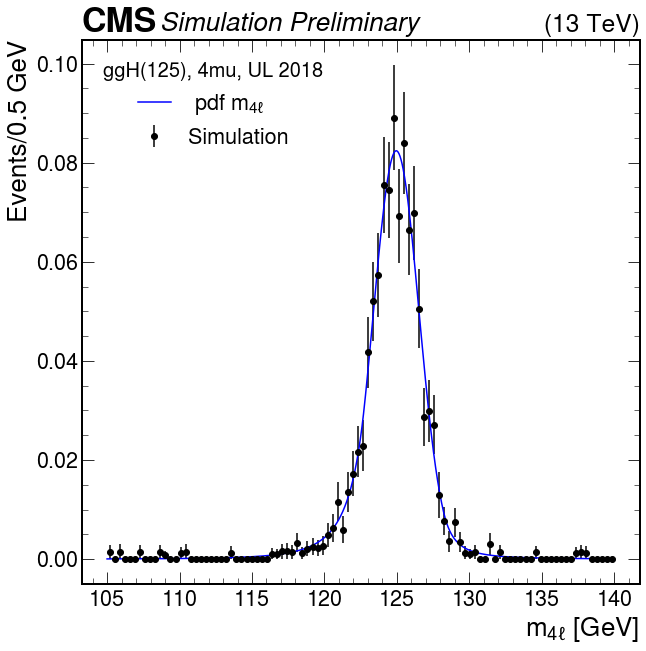

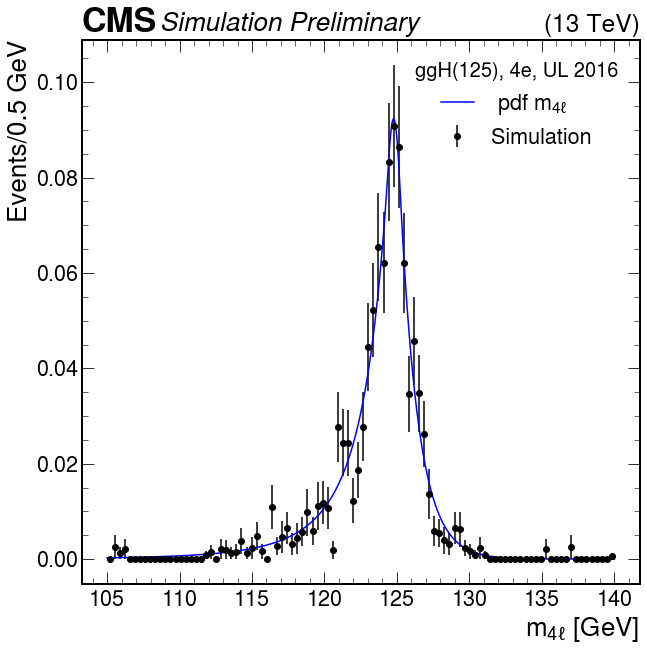

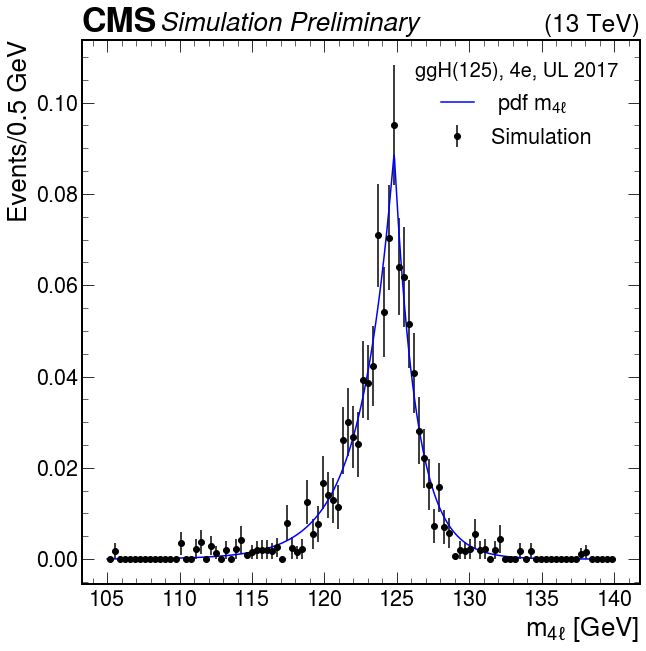

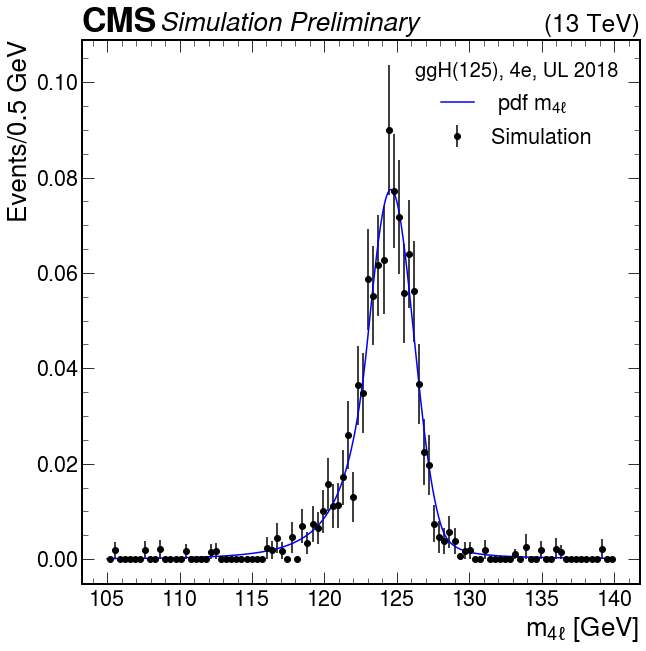

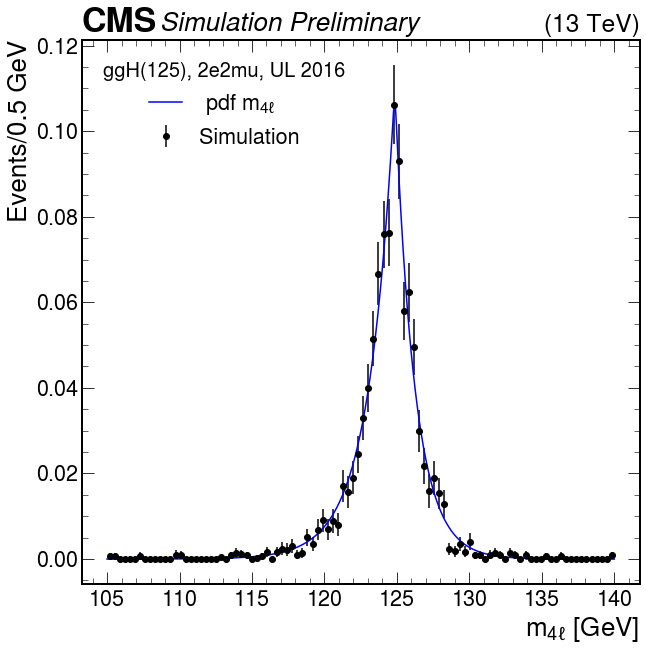

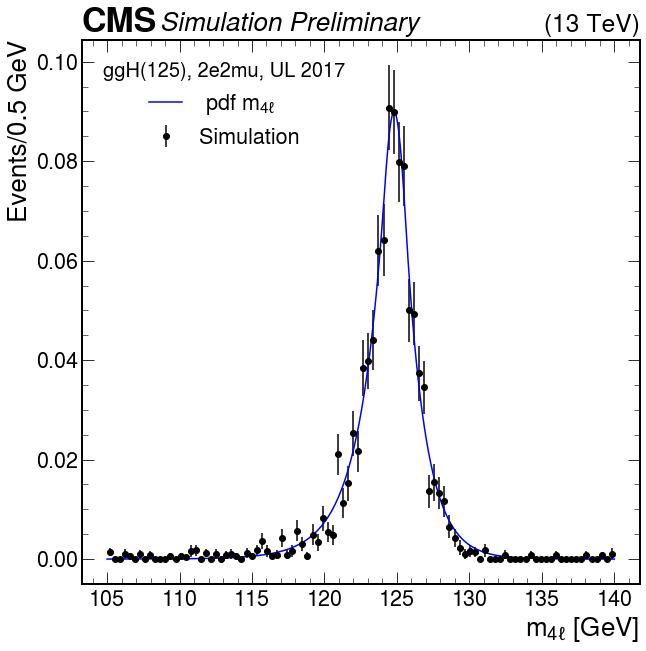

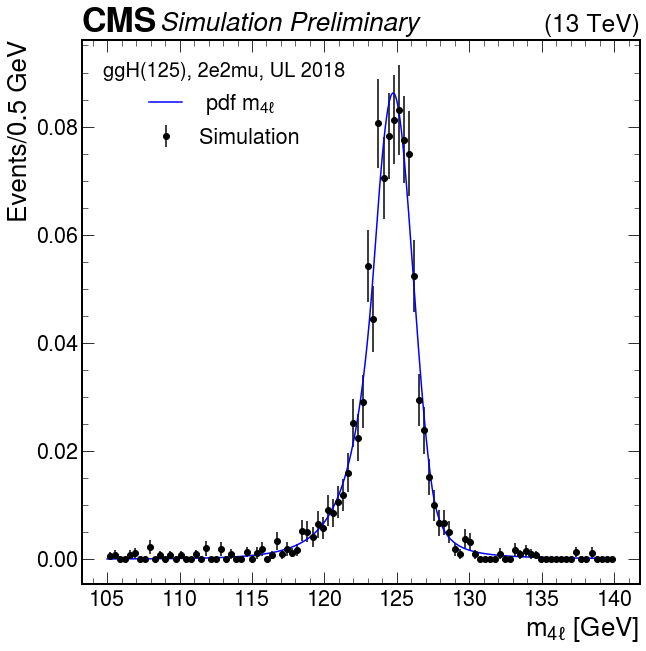

In [14]:
WWW_DEST='pTHParam'
www = f'/eos/home-m/mbonanom/www/Postdoc/HIG-21-009/{WWW_DEST}'
mH='125'
pmode = 'ggH'
boundaries = [0,10,20,30,45,60,80,120,200,13000]

for _bin in range(len(boundaries)-1):
    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        for year in [2016, 2017, 2018]:
            low = boundaries[_bin]
            high = boundaries[_bin+1]
            try:
                _name = fs; _id = idx+1

                x = np.linspace(105, 140, 1000)
                
                zzmass, weight, chan, zzpt = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)
                plt.figure()
                fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d_%d_%d.txt' %(pmode, SUFFIX, _name, year, boundaries[_bin], boundaries[_bin+1])
                os.system(f'cp {fname} {www}/fitParams')
                params = readParams(pmode, _name, year, fname = fname, mH=mH)
                plotPdf_bins(pmode, zzmass, weight, chan, zzpt, _id, params, year, bin_low = low, bin_high = high, suffix=SUFFIX, refit = True, www = f'{www}/fitParams/refit', dumpToTxt=True)

                hep.cms.label(loc=0, label = 'Preliminary')
                plt.xlabel(r'$m_{4\ell}$ [GeV]')
                plt.ylabel('Events/0.5 GeV')
                plt.legend(frameon=False, title = f'{pmode}({mH}), {fs}, UL {year}', title_fontsize = 20)

                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}_{low}_{high}.pdf',bbox_inches='tight')
                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}_{low}_{high}.png',bbox_inches='tight')
            except RuntimeError:
                _name = fs; _id = idx+1

                x = np.linspace(105, 140, 1000)

                zzmass, weight, chan, zzpt = readFile(int(mH), year, pmode = pmode, suffix=SUFFIX)
                plt.figure()
                fname='/eos/user/m/mbonanom/HIG-21-009/sim_massParam_%s_%s_%s_%d_%d_%d.txt' %(pmode, SUFFIX, _name, year, boundaries[_bin], boundaries[_bin+1])
                os.system(f'cp {fname} {www}/fitParams')
                params = readParams(pmode, _name, year, fname = fname, mH=mH)
                plotPdf_bins(pmode, zzmass, weight, chan, zzpt, _id, params, year, bin_low = low, bin_high = high, suffix=SUFFIX, refit = False)

                hep.cms.label(loc=0, label = 'Preliminary')
                plt.xlabel(r'$m_{4\ell}$ [GeV]')
                plt.ylabel('Events/0.5 GeV')
                plt.legend(frameon=False, title = f'{pmode}({mH}), {fs}, UL {year}', title_fontsize = 20)

                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}_{low}_{high}.pdf',bbox_inches='tight')
                plt.savefig(f'{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}_{low}_{high}.png',bbox_inches='tight')

In [31]:
plot_list = []
boundaries = [0,10,20,30,45,60,80,120,200,13000]

for year in [2016, 2017, 2018]:
    for idx, fs in enumerate(['4mu', '4e', '2e2mu']):
        plot_list = []
        _name = fs; _id = idx+1
        for _bin in range(len(boundaries)-1):
            low = boundaries[_bin]
            high = boundaries[_bin+1]
            plot_list.append(f"{www}/HIG-21-009_pdfParam_{pmode}{mH}_{fs}_{year}_{low}_{high}.png")
            
        print("Transforming to video")
        with imageio.get_writer(f'{www}/simFit_ggH_{fs}_{year}.mp4', fps=2) as writer:
            for im in plot_list:
                writer.append_data(imageio.imread(im))
            writer.close()

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x6fd2a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x5b6ea40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x5cbca40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x5d73a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x7386a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x6295a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x6478a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x5d12a40] Warning: data is not aligned! This can lead to a speed loss
IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (646, 651) to (656, 656) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


Transforming to video


[swscaler @ 0x5683a40] Warning: data is not aligned! This can lead to a speed loss
